In [1]:
import math
import random
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd

# Utilities

In [2]:
def dist(p1, p2):
    (x1, y1) = p1
    (x2, y2) = p2
    return int(math.ceil(math.sqrt((x1-x2)**2+(y1-y2)**2)))

In [3]:
def pathLength(P):
    return 0 if len(P)<=1 else \
            dist(P[0], P[1])+pathLength(P[1:])

In [4]:
resolution = 10000

In [5]:
def plotMap(G, T=[], P=[], w=None,
            style='r-o', lw=1, ms=3, 
            styleT='go', msT=5,
            styleP='b-o', lwP=3, msP=1,
            stylePT='go', msPT=7,
            styleW='ro', msW=9,
            text=None, grid=False):
    fig = plt.gcf()
    fig.set_size_inches(6, 6)
    plt.xlim(0,resolution)
    plt.ylim(0,resolution)
    if not grid:
        plt.axis('off')
    V, E = G
    for e in E:
        p1, p2 = e
        plt.plot( [ p1[0], p2[0] ],
                  [ p1[1], p2[1] ], 
                  style, lw=lw, ms=ms)
    for t in T:
        plt.plot( [ t[0] ], [ t[1] ], 
                  styleT, ms=msT)
    plt.plot( [ p[0] for p in P ],
              [ p[1] for p in P ], 
              styleP, lw=lwP, ms=msP)
    for p in P:
        if p in T:
            plt.plot( [ p[0] ], [ p[1] ], 
                      stylePT, ms=msPT)
    if w is not None:
        plt.plot( [ w[0] ], [ w[1] ], 
                      styleW, ms=msW)
    if text is not None:
        plt.text(0.8*resolution, 0, text)
    if grid:
        plt.grid()
    plt.show()

# Plot Routines

In [6]:
def histplot(data, title="", xlabel="", bins=None):
    
    minx = min(data)
    maxx = max(data)
    μ = np.mean(data)
    σ = np.std(data)
    
    fig = plt.figure()
    fig.set_figwidth(4)
    fig.set_figheight(2)
    ax = fig.gca()
        
    if bins is None:
        bins=min((maxx-minx)//5+1,20)
    plt.hist(data, density=True, bins=bins)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.title(title)
        
    x = np.linspace(minx, maxx, 100)
    y = [ stats.norm(loc=μ, scale=σ).pdf(p) for p in x]
    ax.plot(x, y, lw=1, color='red')
    ax.axvline(x=μ, color='red')
    ax.text(μ+0.2,0.9*y[0],'μ='+'%2.2f' % μ, color='red', fontsize=1)
    ax.grid(True)
    plt.show()

In [7]:
def dailyPlot(data, title="", ylabel=""):
    fig = plt.figure()
    fig.set_figwidth(4)
    fig.set_figheight(2)
    ax = fig.gca()
    diff = (max(data)-min(data))*0.1
    ymin = int(math.floor(min(data)-diff))
    ymax = int(math.ceil(max(data)+diff))
    ax.set_ylim(ymin, ymax)
    plt.plot(data, 'bo-', linewidth=1, markersize=5)
    plt.xlabel('Day')
    plt.ylabel(ylabel)
    plt.title(title)
    ax.grid(True)
    plt.show()

In [8]:
def countPlot(count, title=''):
    fig = plt.figure()
    fig.set_figwidth(3)
    fig.set_figheight(2)
    ax = fig.gca()
    xpos = np.arange(0, len(count))
    labels = [ c for c in range(0, len(count)) ]
    ax.set_xticks(xpos, labels)
    plt.title(title)
    plt.bar(range(0, len(count)), count)

# Parameters

The time required for driving is based on the distance between way points at an average speed of 15km/h.

In [9]:
AVERAGE_SPEED = 15/3.6

The **cumulative preparation time** (route planning and 
sorting of the parcels in the delivery order and 
packing the cargo-bike) is assumed to be 50 sec per 
parcel to be delivered.

In [10]:
PREP_TIME_PER_PARCEL = 50

The time to **process returned parcels** in the delivery centre is 30 sec per parcel. 

In [11]:
RETURN_TIME_PER_PARCEL = 30

The average **time to answer the door**.

In [12]:
AVERAGE_TIME_ANSWER_DOOR = 40
HANDOVER = 10
SIGNOFF = 10

In [13]:
#The time for end of day closing procedure
END_TIME = 600

# Floyd-Warshall Algorithm

The following is a modified 
[Floyd-Warshall Algorithm](https://en.wikipedia.org/wiki/Floyd–Warshall_algorithm)
calculating in parallel the distances and the shortest path between vertices in a graph M.

In [14]:
def FW(M):
    
    V, E = M

    n = len(V)
    d = [ [ math.inf for j in range(n) ] for i in range(n) ]
    p = [ [ None for j in range(n) ] for i in range(n) ]

    for (A, B) in E:
        a = V.index(A)
        b = V.index(B)
        d[a][b] = d[b][a] = dist(A, B)
        p[a][b] = [A, B]
        p[b][a] = [B, A]
    
    for i in range(n):
        d[i][i] = 0
        p[i][i] = [V[i]]
    
    for k in range(n):
        for i in range(n):
            for j in range(n):
                dk = d[i][k] + d[k][j]
                if d[i][j] > dk:
                    d[i][j] = dk
                    p[i][j] = p[i][k][:-1] + p[k][j]
                    
    return d, p

In [15]:
import matplotlib.pyplot as plt
import pulp
import math
import random
import numpy as np

resolution = 10000  # city of about 10km diameter

def dist(p1, p2):
    (x1, y1) = p1
    (x2, y2) = p2
    return int(math.sqrt((x1-x2)**2+(y1-y2)**2))

def nearest(X, P):
    minD = math.inf
    minP = None
    for p in P:
        d=dist(X, p)
        if d<minD:
            minP, minD = p, d
    return minP  

def generatePoints(n):
    
    def gen():
        x = int(random.gauss(mu=resolution/2, sigma=resolution/8))
        return min(resolution-50, max(50, x))
    
    mindist = resolution/(2*math.sqrt(n)) 
    # avoid points to neart to each other
    P = []
    while len(P)<n:
        i=len(P)
    
        x0=gen()
        y0=gen()
        
        # don't place new points near existing points
        P.append((x0,y0))
        for j in range(0,i):
            if dist(P[i],P[j])<mindist:
                P=P[:-1]
                break
    return P

def equalLines(l1, l2):
    if l1==l2:
        return True
    else:
        return l1[0]==l2[1] and l1[1]==l2[0]
    
def rev(L):
    return L[1],L[0]

def solve(x11, x12, y1, x21, x22, y2):
    
    def Det(x11, x12, x21, x22):
        return x11*x22-x21*x12

    D = Det(x11, x12, x21, x22)
    Ds = Det(y1, x12, y2, x22)
    Dt = Det(x11, y1, x21, y2)
    if D==0:
        return False
    s=Ds/D
    t=Dt/D
    return 0 <= s and s <= 1 and 0 <= t and t <= 1
    
def intersecting(l1, l2):
    p1, p2 = l1
    q1, q2 = l2
    if p1==q1 or p1==q2 or p2==q1 or p2==q2:
        return False
    xp1, yp1 = p1
    xp2, yp2 = p2
    xq1, yq1 = q1
    xq2, yq2 = q2
    return solve(xp2-xp1, xq1-xq2, xq1-xp1,
                 yp2-yp1, yq1-yq2, yq1-yp1)

def equalTriangles(t1, t2):
    P1, P2, P3 = t1
    Q1, Q2, Q3 = t2
    if P1==Q1:
        if P2==Q2:
            return P3==Q3
        elif P2==Q3:
            return P3==Q2
        else:
            return False
    elif P1==Q2:
        if P2==Q1:
            return P3==Q3
        elif P2==Q3:
            return P3==Q1
        else:
            return False
    elif P1==Q3:
        if P2==Q1:
            return P3==Q2
        elif P2==Q2:
            return P3==Q1
        else:
            return False
    else:
        return False
    
def removeTriangle(t, T):
    for tt in T:
        if equalTriangles(t, tt):
            T.remove(tt)
            return True
    return False   

def addTriangle(t, T):
    for tt in T:
        if equalTriangles(t, tt):
            return
    T.append(t)  

def area(p1, p2, p3):
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    return abs(x1*(y2-y3)+x2*(y3-y1)+x3*(y1-y2))/2

def insideTriangle(x, t):
    p, q, r = t
    if x==p or x==q or x==r:
        return False
    return abs(area(p,q,x) + area(p,r,x)+ area(q,r,x) - area(p,q,r))<0.00001 

def sides(t):
    A, B, C = t
    return [(B, C), (C, A), (A, B)]

def longestSide(t):
    return sorted(sides(t), key=lambda s: dist(s[0], s[1]), reverse=True)[0]

def commonSide(t1, t2):
    S1 = sides(t1)
    S2 = sides(t2)
    for s1 in S1:
        for s2 in S2:
            if equalLines(s1, s2):
                return s1
    return None

def oppositePoint(t, l):
    A, B, C = t
    P, Q = l
    if A==P:
        return C if B==Q else B
    elif A==Q:
        return C if B==P else B
    else:
        return A
    
def intersectingTriangles(c1, c2):
    c= commonSide(c1, c2)
    if c is None:
        return False
    A, B = c
    C1 = oppositePoint(c1, c)
    C2 = oppositePoint(c2, c)
    return intersecting((A, C1), (B,C2)) or \
            intersecting((A, C2), (B, C1))

def intersectingLines(c1, c2):
    c= commonSide(c1, c2)
    if c is None:
        return None
    A, B = c
    C1 = oppositePoint(c1, c)
    C2 = oppositePoint(c2, c)
    if intersecting((A, C1), (B,C2)):
        return (A, C1), (B,C2)
    elif intersecting((A, C2), (B, C1)):
        return (A, C2), (B, C1)
    else:
        return None

def defuse(t1, t2):
    # is only called if intersectingTriangles(t1, t2)
    l1, l2 = intersectingLines(t1, t2)
    c = commonSide(t1, t2)
    if c is None:
        return None
    A, B = c
    C1 = oppositePoint(t1, c)
    C2 = oppositePoint(t2, c)
    if intersecting((A, C1), (B,C2)):
        return [C1, C2, A]
    elif intersecting((A, C2), (B, C1)):
        return [C1, C2, B]
    
def slimTriangle(t):
    A, B, C = t
    a = dist(B,C)
    b = dist(A,C)
    c = dist(A,B)
    [a, b, c] = sorted([a, b, c])
    return a+b<1.07*c

def plotTriangle(t, style='r-o', lw=1, ms=3):
    p1, p2, p3 = t
    plt.plot( [ p1[0], p2[0], p3[0], p1[0] ],
              [ p1[1], p2[1], p3[1], p1[1] ], 
              style, lw=lw, ms=ms)

def plotTriangles(T, style='r-o', lw=1, ms=3):
    plt.xlim(0,resolution)
    plt.ylim(0,resolution)
    plt.axis('off')
    for t in T:
        plotTriangle(t, style, lw=lw, ms=ms)
    plt.show()
    

def triangulation(P, show=False):
    x = [ p[0] for p in P ]
    y = [ p[1] for p in P ]
    minx = min(x)
    maxx = max(x)
    miny = min(y)
    maxy = max(y)
    nmaxx = 1.1 * maxx
    nmaxy = 1.1 * maxy
    nminx = max(0.5 * minx, 0)
    nminy = max(0.5 * miny, 0)
    distx = nmaxx-nminx
    disty = nmaxy-nminy
    d = math.sqrt(distx*disty/(2*len(P)))
    dx = math.ceil(distx/d)
    dy = math.ceil(disty/d)

        
    def kx(i):
        return nminx+i*d
    
    def ky(j):
        return nminy+j*d
    
    def k(i, j):
        return (kx(i), ky(j))
    
    # def n(i, j):
    #     return nearest( (kx(i), ky(j)), P)
    def n(i, j):
        X = (kx(i), ky(j))
        minD = math.inf
        minP = None
        for p in P:
            d=dist(X, p)
            if d<minD:
                minP, minD = p, d
        return minP  

    if show:

        plt.figure(0)
        plt.xlim(0,resolution)
        plt.ylim(0,resolution)
        plt.axis('off')
    
        plt.plot([ p[0] for p in P ], 
                 [ p[1] for p in P ], 'ro', ms=10)    
    
        for i in range(0, dx+1):
            for j in range(0, dy):
                plt.plot( [ kx(i), kx(i) ],
                          [ ky(j), ky(j+1) ], 'b:.')
            
        for j in range(0, dy+1):
            for i in range(0, dx):
                plt.plot( [ kx(i), kx(i+1) ],
                          [ ky(j), ky(j) ], 'b:.')
            
        for i in range(0, dx):
            for j in range(0, dy):
                plt.plot( [ kx(i), kx(i+1) ],
                          [ ky(j), ky(j+1) ], 'b:.')
    
        for i in range(0, dx+1):
            for j in range(0, dy+1):
                nx, ny = n(i,j)
                plt.plot( [ kx(i), nx ],
                          [ ky(j), ny ], 'g:')


    
    # set of triangles
    T = []
    for i in range(0, dx):
        for j in range(0, dy):
            p1=n(i,j)
            p2=n(i+1, j)
            p3=n(i, j+1)
            p4=n(i+1, j+1)
            if p1!=p2 and p2!=p4 and p4!=p1:
                addTriangle([p1, p2, p4], T)
            if p1!=p3 and p3!=p4 and p4!=p1:
                addTriangle([p1, p3, p4], T)
                  
    # Replace a triangle containing an inner point
    # with three triangles formed from this inner point
    C = T.copy()
    for p in P:
        for t in T:
            if insideTriangle(p, t):
                p1, p2, p3 = t
                C.remove(t)
                C.append( (p1, p2, p) )
                C.append( (p2, p3, p) )
                C.append( (p3, p1, p) )
         
    PLOT = 0
    
    def showTriangulation(T, style='r-o', check=False):
        nonlocal PLOT
        PLOT += 1
        plt.figure(PLOT)
        plt.xlim(0,resolution)
        plt.ylim(0,resolution)
        plt.axis('off')
        for t in T:
            plotTriangle(t, 'r-o', lw=0.5)
        
        if check:
            found=False
            for t1 in T:
                for t2 in T:
                    if t1!=t2 and intersectingTriangles(t1, t2):
                        plotTriangle(t1, 'b-o')
                        plotTriangle(t2, 'g-o')
                        found=True
                        break
                if found:
                    break
  
    found = True
    while found:
        
        if show:
            showTriangulation(C)
        
        D=C.copy()
        found = False
        for c1 in C:
            for c2 in C:
                if c1!=c2 and intersectingTriangles(c1, c2):
                    # print(f"replacing")
                    # print(triangle_String(c1))
                    # print(triangle_String(c2))
                    c3=defuse(c1, c2)
                    removeTriangle(c2, D)
                    # print(triangle_String(c3))
                    addTriangle(c3, D)
                    found=True
                    break
            if found:
                break
        C=D
        
    
    
    def isolated(p, C):
        for c in C:
            p1, p2, p3 = c
            if p==p1 or p==p2 or p==p3:
                return False
        return True
    
    for p in P:
        if isolated(p, D):
            plt.plot( [ p[0] ], [ p[1] ], 'ko', ms=15)
                    
    return C

#Graphs
def element(p, S):
    for s in S:
        if s==p: # s[0]==p[0] and s[1]==p[1]:
            return True
    return False
        
def vertices(T):
    S = []
    for t in T:
        A, B, C = t
        if not element(A, S):
            S.append(A)
        if not element(B, S):
            S.append(B)
        if not element(C, S):
            S.append(C)
    return sorted(S, key=lambda p: p[0])

def edges(T):
    S = []
    for t in T:
        A, B, C = sides(t)
        if not element(A, S) and not element(rev(A), S):
            S.append(A)
        if not element(B, S) and not element(rev(B), S):
            S.append(B)
        if not element(C, S) and not element(rev(C), S):
            S.append(C)
    return sorted(S, key=lambda p: p[0][0])

def graph(T):
    return vertices(T), edges(T)

#Lines and Paths

def pathLength(P):
    return 0 if len(P)<=1 else \
            dist(P[0], P[1])+pathLength(P[1:])

def reverse(P):
    return [ P[-i] for i in range(1,len(P)+1) ]

def index(x, L):
    for i in range(len(L)):
        if x==L[i]: 
            return i
    return NoneshortestPath

def addWithoutDuplicates(L, X):
    for i in range(len(X)):
        if X[i] not in L:
            L.append(X[i])
    return L

## Maps
def createMap(P, p=0.2):
    T = triangulation(P)
    V, E = graph(T)
    
    for t in T:
        if slimTriangle(t):
            s = longestSide(t)
            if s in E:
                E.remove(s)
            elif (s[1], s[0]) in E:
                E.remove((s[1], s[0]))
        else:
            for tt in T:
                if not equalTriangles(t, tt):
                    s = commonSide(t, tt)
                    if s is None:
                        continue
                    if random.random()<p:
                        if s in E:
                            E.remove(s)
                            break
                        elif (s[1], s[0]) in E:
                            E.remove((s[1], s[0]))
                            break
                    
    return V, E

## Place Warehouse Somewhere Inside
def placeWarehouse(M):
    V, _ = M
    dmin = math.inf
    pos = (random.randint(resolution/4, resolution*3/4),
            random.randint(resolution/4, resolution*3/4))
    for p in V:
        dp = dist(p, pos)
        if dp<dmin:
            w = p
            dmin = dp
    return w

## Generate Delivery Points

def splitEdge(V, E, s):
    A, B = s
    p = random.uniform(0.2,0.8)
    x = int(A[0]+p*(B[0]-A[0]))
    y = int(A[1]+p*(B[1]-A[1]))
    t = (x,y)
    E.remove(s) 
    E.append((A, t))
    E.append((t, B))
    V.append(t)
    return (V, E), t

def addTargets(M, n=5):
    V, E = M
    V, E = V.copy(), E.copy()
    T = []
    # we want to ensure that the beginning of the 
    # sequence of points generated randomly stays
    # the same
    mindist = 0.05
    while len(T)<n:
        S = random.sample(E, 1)
        s = S[0]
        A, B = s
        if dist(A,B)>resolution/20: # avoid targets placed narrowly
            (V, E), t = splitEdge(V, E, s)
            T.append(t)
    return (V, E), T

## Plot Map with Delivery Route

def plotMap(G, T=[], P=[], w=None,
            style='r-o', lw=1, ms=3, 
            styleT='go', msT=5,
            styleP='b-o', lwP=3, msP=1,
            stylePT='go', msPT=7,
            styleW='bo', msW=7,
            text=None, grid=False):
    fig = plt.gcf()
    fig.set_size_inches(6, 6)
    plt.xlim(0,resolution)
    plt.ylim(0,resolution)
    if not grid:
        plt.axis('off')
    V, E = G
    for e in E:
        p1, p2 = e
        plt.plot( [ p1[0], p2[0] ],
                  [ p1[1], p2[1] ], 
                  style, lw=lw, ms=ms)
    for t in T:
        plt.plot( [ t[0] ], [ t[1] ], 
                  styleT, ms=msT)
    plt.plot( [ p[0] for p in P ],
              [ p[1] for p in P ], 
              styleP, lw=lwP, ms=msP)
    for p in P:
        if p in T:
            plt.plot( [ p[0] ], [ p[1] ], 
                      stylePT, ms=msPT)
    if w is not None:
        plt.plot( [ w[0] ], [ w[1] ], 
                      styleW, ms=msW)
    if text is not None:
        plt.text(0.8*resolution, 0, text)
    if grid:
        plt.grid()
    plt.show()
    
    ## Generate Data
def generateData(seed=None, nodes=50, customers=100, 
                 plot=False, log=False):

    if seed is None:

        print("Usage:  M, W, C = generateData(seed=None, ")
        print("                               nodes=35, customers=75, ")
        print("                               plot=False, log=False)")
        print("")
        print("  seed  the seed value to be used for data generation. ")
        print("        To test the application use seed=0, it will create")
        print("        a small map, with a very few customer locations and")
        print("        a small set of delivery data.")
        print("")
        print("  nodes the number of intersections in the generated map")
        print("")
        print("  customers  the number of customers generated on the map")
        print("")
        print("  log   Controls print output during data generation.")
        print("")
        print("  plot  Controls graphical output during data generation.")
        print("")
        print("Returns:")
        print("")
        print("  M = (V, E) is the generated map given as a graph")
        print("    where V is a list of vertices, with each vertice ")
        print("    given as a pair (x, y) of integer coordinates, ")
        print("    and E is a list of edges, with each edge given")
        print("    as a pair (A, B) of vertices, with each vertex again")
        print("    given as a pair (x, y) of integer coordinates")
        print("")
        print("  W ∈ V  is the location of the distribution warehouse")
        print("    given as a pair (x, y) of integer coordinates")
        print("")
        print("  C ⊆ V  is a list of customer locations")
        print("    given as pairs (x, y) of integer coordinates")
        print("    len(C) gives the number of customers generated")
        print("")
        
        seed = 0
    
    if seed==0:          # generate very simple test data 
        nodes = 10       # number of points in map
        customers = 5    # number of  customers
        grid = True
            
    else:
        grid = False
        
    random.seed(seed)
    
    P = generatePoints(nodes)
    
    M = createMap(P)
    W = placeWarehouse(M)
    MT, C = addTargets(M, customers)

    if log:
        print(f"Generated map with {nodes:d} nodes and " 
              f"{customers:d} customer locations")
    if plot:
        label="" if seed==0 else f"seed={seed:4d}"
        plotMap(MT, T=C, w=W, text=label, grid=grid)
    
    return MT, W, C

Generated map with 50 nodes and 100 customer locations


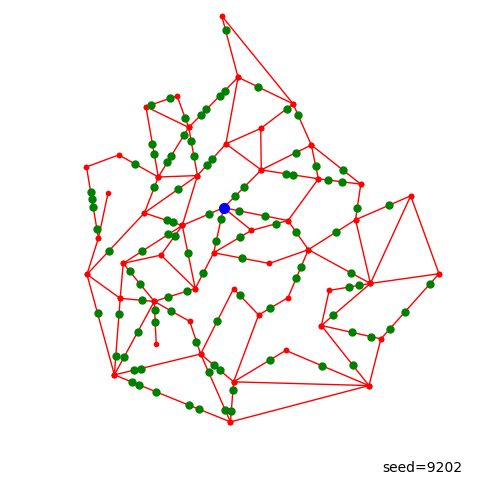

In [16]:
data = generateData(seed=9202, customers= 100, log=True, plot=True)

In [17]:
import pickle
with open('data.pickled', 'wb') as f:
    pickle.dump(data, f)

In [18]:
import pickle
with open('data.pickled', 'rb') as f:
    M, W, C = pickle.load(f)

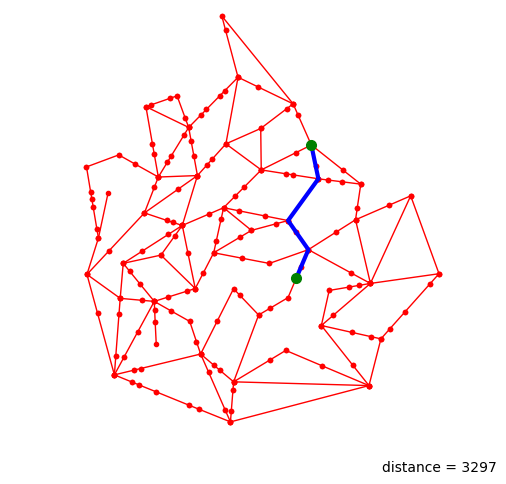

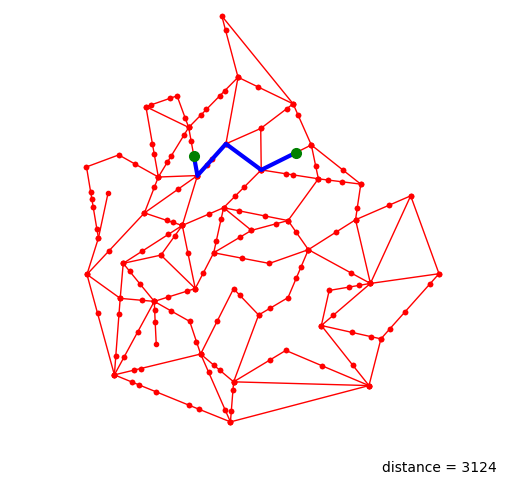

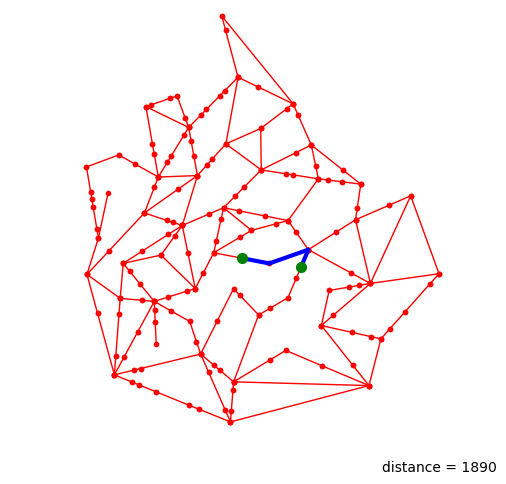

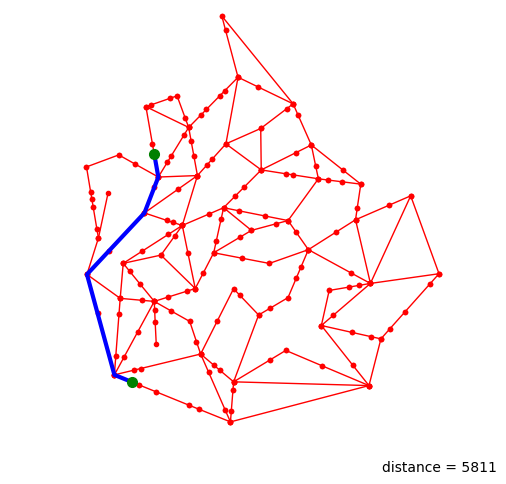

In [19]:
V, E = M
d, p = FW(M)
for i in range(4):
    [A, B] = random.sample(V, k=2)
    a = V.index(A)
    b = V.index(B)
    plotMap(M, T=[A, B], P=p[a][b], text=f"distance = {d[a][b]:d}")

# Time Handling

**Convention:** In this project we measure time in seconds. The simulation will start at 0:00. Time related methods will be added as they are needed.

`timestamp(t)` generates a timestamp string in the form `[dd] hh:mm:ss.d`

In [20]:
def timestamp(t):
    day = int(t)//(24*3600)
    t = t - day*24*3600
    hour = int(t)//3600
    t = t - hour*3600
    mins = int(t)//60
    t = t - mins*60
    secs = int(t)
    t = int(round((t - secs)*10))
    return f"[{day:2d}] {hour:02d}:{mins:02d}:{secs:02d}.{t:1d}"

In [21]:
timestamp(24*3600*3+17*3600+615.1)

'[ 3] 17:10:15.1'

In [22]:
def nextHour(env, hour):
    beginningOfDay = int(env.now//(24*3600))*24*3600
    timeOfDay = env.now-beginningOfDay
    if hour*3600 > timeOfDay:
        return hour*3600 - timeOfDay
    else:
        return hour*3600 + 24*3600 - timeOfDay

In [23]:
def day(now):
    return int(now//(24*3600))

# Generate Data

In [24]:
def generateParcels(days=50, customers=100, p=0.25, plot=False, log=False):
    parcelsForCustomersPerDay = [ [] for i in range(days) ]
    parcelsPerCustomer = [ 0 for i in range(customers) ]
    parcelsPerDay = [ 0 for i in range(days) ]

    for c in range(customers):
        cp = []
        t = random.expovariate(p/(24*3600)) # arrival time secs
        d = day(t)
        deliveryDays = []
        while d<days:
            if d not in deliveryDays:
                deliveryDays.append(d)
            parcelsForCustomersPerDay[d].append(c)
            parcelsPerDay[d] += 1
            parcelsPerCustomer[c] += 1
            cp.append(d)
            t += random.expovariate(p/(24*3600))
            d = day(t)
            
        if log:
            print(f"customer {c:3d} expects {len(cp):2d} deliveries "
                  f"on {len(deliveryDays):2d} days")
            # print(cp)
        
    if plot:
        
        histplot(parcelsPerCustomer,
                 xlabel=f'Number of Parcels (over {days:3,d} days)',
                 title='Number of Parcels per Customer')
        
        histplot(parcelsPerDay,
                 xlabel=f'Number of Parcels (for {customers:3,d} customers)',
                 title='Number of Parcels per Customer')
        
    return parcelsForCustomersPerDay

## Testing Data Generation

In [25]:
generateParcels(days=50, customers=100, p=0.3, log=True)

customer   0 expects 16 deliveries on 14 days
customer   1 expects 16 deliveries on 14 days
customer   2 expects 13 deliveries on 13 days
customer   3 expects 15 deliveries on 13 days
customer   4 expects 18 deliveries on 16 days
customer   5 expects  8 deliveries on  8 days
customer   6 expects 11 deliveries on 11 days
customer   7 expects 18 deliveries on 16 days
customer   8 expects 12 deliveries on 11 days
customer   9 expects 12 deliveries on 11 days
customer  10 expects 19 deliveries on 18 days
customer  11 expects 16 deliveries on 14 days
customer  12 expects 11 deliveries on 10 days
customer  13 expects 18 deliveries on 14 days
customer  14 expects 16 deliveries on 14 days
customer  15 expects 18 deliveries on 16 days
customer  16 expects 16 deliveries on 12 days
customer  17 expects 15 deliveries on 13 days
customer  18 expects  9 deliveries on  8 days
customer  19 expects  8 deliveries on  7 days
customer  20 expects 12 deliveries on 11 days
customer  21 expects 14 deliveries

[[3,
  4,
  4,
  9,
  9,
  12,
  14,
  15,
  16,
  16,
  18,
  22,
  24,
  27,
  30,
  35,
  36,
  39,
  43,
  47,
  61,
  62,
  65,
  66,
  72,
  76,
  79,
  86,
  87,
  88,
  92],
 [2,
  3,
  6,
  10,
  15,
  21,
  23,
  26,
  26,
  32,
  34,
  35,
  38,
  38,
  40,
  41,
  43,
  43,
  45,
  57,
  59,
  63,
  65,
  68,
  70,
  71,
  74,
  76,
  82,
  83,
  89,
  90,
  95],
 [1,
  3,
  4,
  10,
  11,
  13,
  13,
  14,
  17,
  20,
  22,
  37,
  38,
  42,
  43,
  43,
  44,
  47,
  53,
  62,
  65,
  68,
  68,
  70,
  72,
  78,
  81,
  86,
  86,
  97,
  98],
 [3,
  6,
  8,
  9,
  13,
  15,
  16,
  18,
  32,
  33,
  38,
  47,
  58,
  59,
  60,
  66,
  72,
  73,
  76,
  82,
  84,
  85,
  85,
  89,
  90,
  97,
  97,
  98,
  99],
 [1,
  15,
  25,
  30,
  45,
  52,
  53,
  54,
  56,
  60,
  61,
  64,
  67,
  74,
  79,
  79,
  84,
  89,
  89,
  92,
  93,
  94,
  95,
  95],
 [0,
  1,
  2,
  10,
  17,
  18,
  20,
  22,
  34,
  39,
  40,
  40,
  43,
  53,
  60,
  63,
  74,
  76,
  77,
  79,
  80,


# Create Roundtrip

In [26]:
import pulp

In [27]:
def roundtrips(x, n):
    
    def isElem(x, l):
        for i in range(len(l)):
            if l[i]==x:
                return True
        return False

    def startpoint(trips):
        for i in range(n):
            for t in trips:
                if isElem(i, t):
                    break
            else:
                return i
    
    def totalLength(trips):
        s=0
        for i in range(0, len(trips)):
            s += len(trips[i])-1
        return s

    trips = []
    while totalLength(trips)<n:
        start = startpoint(trips)
        trip = [ start ]
        i = start
        while len(trip) < n-totalLength(trips):
            for j in range(0, n):
                if pulp.value(x[i][j])==1:
                    trip.append(j)
                    i=j
                    break        
            if pulp.value(x[trip[-1]][start])==1:
                trip.append(start)
                break
        trips.append(trip)
    return sorted(trips, key=lambda t: len(t), reverse=True)

In [28]:
def createLoop(M, D, P, T):
    V, E = M
    n = len(T)
    # create variables
    x = pulp.LpVariable.dicts("x", ( range(n), range(n) ),
                            lowBound=0, upBound=1, cat=pulp.LpInteger)
    # create problem
    prob = pulp.LpProblem("Loop",pulp.LpMinimize)
    # add objective function
    prob += pulp.lpSum([ D[V.index(T[i])][V.index(T[j])]*x[i][j] 
                             for i in range(n) for j in range(n) ])
    # add constraints
    constraints=0
    for j in range(n):
        prob += pulp.lpSum([ x[i][j] for i in range(n) if i!=j ]) ==1
    constraints += n
    for i in range(n):
        prob += pulp.lpSum([ x[i][j] for j in range(n) if i!=j ]) ==1
    constraints += n
    for i in range(n):
        for j in range(n):
            if i!=j:
                prob += x[i][j]+x[j][i] <= 1
                constraints += 1
    # initialise solver
    solvers = pulp.listSolvers(onlyAvailable=True)
    solver = pulp.getSolver(solvers[0], msg=0)
    # print(f"{constraints:d} Constraints")
    prob.solve(solver)
    trips = roundtrips(x, n)
    while len(trips)>1:
        for t in trips:
            prob += pulp.lpSum([ x[t[i]][t[i+1]] + x[t[i+1]][t[i]]
                            for i in range(0,len(t)-1) ]) <= len(t)-2
            constraints += 1
        # print(f"{constraints:d} Constraints")
        prob.solve(solver)
        trips = roundtrips(x, n)
    trip = trips[0]
    # print(trip)
    loop = []
    for k in range(len(trip)-1):
        sub = P[V.index(T[trip[k]])][V.index(T[trip[k+1]])]
        loop += sub if len(loop)==0 else sub[1:]
    return loop

## Testing Generating Roundtrip

In [29]:
D, P = FW(M)

In [30]:
customers = random.sample(C, k=25)

In [31]:
L = createLoop(M, D, P, [W]+customers)

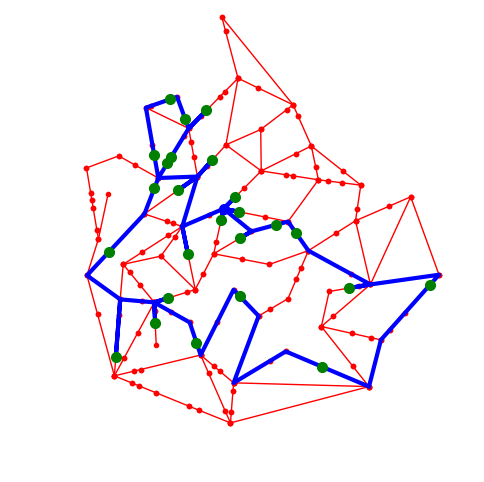

In [32]:
plotMap(M, T=customers, P=L, w=W)

# Recorder

In [33]:
class Recorder:
    
    def __init__(self, env, M, W, C, days, parcels,
                 log=False, plot=False):
        self.env = env
        self.M = M
        self.W = W
        self.C = C
        self.days = days
        self.parcels = parcels
        self.log = log
        self.plot = plot
        Customer.REGISTER = []
        Parcel.REGISTER = []
        
        # create a data frame for records per working day
        self.daily = pd.DataFrame()
        self.daily['begin'] = [None]*days
        self.daily['end'] = [None]*days
        self.daily['dist'] = [None]*days
        self.daily['left'] = [None]*days
        
        # create a data frame for records per parcel
        self.precs = pd.DataFrame()
        self.precs['arrived'] = [None]*parcels
        self.precs['delivered'] = [None]*parcels
        
    def trace(self, event):
        if self.log:
            print(timestamp(self.env.now), event)
            
    def recordDriverBeginsWork(self):
        self.trace("Driver arrives for work")
        self.daily.at[day(self.env.now), 'begin'] = int(round(self.env.now))
        
    def recordDriverEndsWork(self):
        self.trace("Driver goes home")
        self.daily.at[day(self.env.now), 'end'] = int(round(self.env.now))
 
    def recordTourLength(self, length):
        self.daily.at[day(self.env.now), 'dist'] = int(length)

    def recordParcelsLeftOver(self, numberOfParcels):
        self.trace(f"{numberOfParcels:d} left over for next day")
        self.daily.at[day(self.env.now), 'left'] = numberOfParcels
        
    def recordParcelArrival(self, parcel):
        self.trace(f"{str(parcel):s} arrived in delivery centre")
        self.precs.at[parcel.i, 'arrived'] = day(self.env.now)
        
    def recordParcelDelivery(self, parcel):
        self.trace(f"{str(parcel):s} delivered to customer")
        self.precs.at[parcel.i, 'delivered'] = day(self.env.now)
          
    def finish(self):
        self.daily['time'] = self.daily['end']-self.daily['begin']
        
        for i in range(self.parcels):
            if self.precs.at[i, 'delivered'] is None:
                self.precs.at[i, 'delivered'] = self.days
        self.precs['delay'] = self.precs['delivered']-self.precs['arrived']
        
        # calculate max delay time of parcels delivered on a day
        self.daily['maxdelay'] = [0] * self.days
        for i in range(self.parcels):
            deliveryDay = self.precs.at[i, 'delivered']
            if deliveryDay < self.days:
                if self.daily.at[deliveryDay, 'maxdelay'] < self.precs.at[i, 'delay']:
                    self.daily.at[deliveryDay, 'maxdelay'] = self.precs.at[i, 'delay']
                    
    def histWorkingTime(self):
        histplot(self.daily['time']//60,
                 xlabel='Working Time [min]',
                 title='Daily Working Time')
        
    def plotWorkingTime(self):
        dailyPlot(self.daily['time']//60,
                  ylabel='Working Time [min]',
                  title='Daily Working Time')
        
    def histTourLength(self):
        histplot(self.daily['dist'],
                 xlabel='Tour Length [m]',
                 title='Daily Tour Length')
                
    def plotTourLength(self):
        dailyPlot(self.daily['dist'],
                  ylabel='Tour Length [m]',
                  title='Daily Tour Length')
        
    def histLeftOver(self):
        histplot(self.daily['left'],
                 xlabel='Left-Over Parcels',
                 title='Daily Left-Over Parcels')
                
    def plotLeftOver(self):
        dailyPlot(self.daily['left'],
                  ylabel='Number of Parcels',
                  title='Daily Left-Over Parcels')
        
    def plotParcelDelay(self):
        dailyPlot(self.daily['maxdelay'],
                  ylabel='Max Delay [days]',
                  title='Max Delivery Delay')
        
    def countplotParcelDelay(self):
        maxDelay = max(self.precs['delay'])
        count = [ 0 for c in range(maxDelay+1) ]
        for i in range(self.parcels):
            count[self.precs.at[i, 'delay']] += 1
        countPlot(count, title='Parcel Delay [days]')
        
    def tableParcelDelay(self):
        maxDelay = max(self.precs['delay'])
        count = [ 0 for c in range(maxDelay+1) ]
        for i in range(self.parcels):
            count[self.precs.at[i, 'delay']] += 1
        print(f'Delivery Delay ({self.parcels:d} parcels)')
        print(f'{"None":>7s}:   {count[0]:4d}   {count[0]/self.parcels*100:4.1f}%')
        for c in range(1, len(count)):
            print(f'{c:2d} days:   {count[c]:4d}   {count[c]/self.parcels*100:4.1f}%')

# Model

## Class Parcel

Parcels follow through a sequence of states:
- processing
- in transit (from manufacture to distribution centre)
- arrived in distribution centre
- ready for delivery 
- out for delivery
- customer not present
- returned to distribution centre
- delivered

In [34]:
class Parcel:
    
    REGISTER = []
    
    def __init__(self, rec, i, cust):
        self.rec = rec
        self.i = i  # row index in data frames of input data
        self.cust = cust
        self.dest = cust.location
        self.status = [ 'processing' ] # status record and
        self.timing = [ self.rec.env.now ]      # timing
        assert(len(Parcel.REGISTER)==i)
        Parcel.REGISTER += [ self ] 

    def __str__(self):
        return f"Parcel: {self.i:2d} for customer {self.cust.i:d}"
    
    def __reg(self, state):
        self.status += [ state ]
        self.timing += [ self.rec.env.now ]
        self.rec.trace(str(self)+" "+state)
        
    def arrivedAtDeliveryCentre(self):
        self.__reg('arr at delivery centre')
        
    def outForDelivery(self): 
        self.__reg('out for delivery')
        
    def returnFromDelivery(self):
        self.__reg('return from delivery')
        
    def delivered(self):
        self.rec.recordParcelDelivery(parcel)
        self.__reg('delivered to customer')

## Class Customer

In [35]:
class Customer:
    
    REGISTER = []

    def __init__(self, rec, location):
        self.rec = rec
        self.location = location
        self.i = len(Customer.REGISTER)
        Customer.REGISTER += [ self ]
        self.atHome = True
        self.answersDoor = False
        self.parcelsReceived = []
        rec.env.process(self.process())
        
    def __str__(self):
        return f"Customer: {self.i:2d} {str(self.location):s}"
    
    # factory method ensures that there is only
    # one customer per location
    def getCustomer(rec, location):
        for c in Customer.REGISTER:
            if c.location == location:
                return c
        return Customer(rec, location)
    
    def leaveHouse(self):
        assert(self.atHome and not self.answersDoor)
        self.rec.trace(str(self)+" leaves house")
        self.atHome = False
     
    def returnHome(self):
        assert(not self.atHome)
        self.rec.trace(str(self)+" returns home")
        self.atHome = True
        
    def answerDoor(self):
        if self.atHome:
            yield self.rec.env.timeout(random.expovariate(1/AVERAGE_TIME_ANSWER_DOOR))
            self.rec.trace(str(self)+" answers door")
            self.answersDoor = True
        else:
            yield self.rec.env.timeout(WAIT_TIME_IF_CUSTOMER_DOESNT_ANSWER_DOOR)
            self.rec(str(self)+" not at home")
            
    def acceptParcel(self, parcel):
        assert(self.answersDoor)
        self.parcelsReceived += [parcel]
        self.rec.recordParcelDelivery(parcel)
        self.rec.trace(str(self)+" accepts Parcel "+str(parcel.i))
        
    def signOff(self):
        assert(self.answersDoor)
        self.rec.trace(str(self)+" signs off")
        self.answersDoor = False
        
    def process(self):
        yield self.rec.env.timeout(nextHour(self.rec.env, 8))
        while day(self.rec.env.now)<self.rec.days:
            # in a refinement we may use random times
            self.leaveHouse()
            yield self.rec.env.timeout(nextHour(self.rec.env, 18))
            self.returnHome()
            yield self.rec.env.timeout(nextHour(self.rec.env, 8))

## Class Driver

In [36]:
class Driver:
    
    def __init__(self, rec, DC):
        self.rec = rec
        self.DC = DC
        self.location = None
        self.parcels = None
        self.tour = None
        self.rec.env.process(self.process())
        
    # activity
    def __drive(self, target):
        assert(self.tour[0] == self.location)
        while self.location!=target:
            d = dist(self.location, self.tour[1])
            yield self.rec.env.timeout(d / AVERAGE_SPEED)
            self.location = self.tour[1]
            self.tour = self.tour[1:]
        assert(self.tour[0] == self.location == target)
    
    def arriveForWork(self):
        self.location = self.DC.W
        self.parcels = []
        self.returns = []
        self.tour = [ self.DC.W ]
        self.rec.recordDriverBeginsWork()
        
    def leaveForDelivery(self, tour, parcels):
        self.tour, self.parcels = tour, parcels
        self.rec.trace(f"Driver leaves for delivery " \
                       f"of {len(parcels):d} parcels")
        
    def process(self):
        yield self.rec.env.timeout(nextHour(self.rec.env, 18))
        while day(self.rec.env.now)<self.rec.days:
            self.arriveForWork()
            tour, parcels = self.DC.sendForDelivery()
            yield self.rec.env.timeout(PREP_TIME_PER_PARCEL*len(parcels))
            self.rec.recordTourLength(pathLength(tour))
            self.leaveForDelivery(tour, parcels)        
            while len(self.parcels)>0:
                # drive to customer
                custLocation = self.parcels[0].dest
                cust = Customer.getCustomer(self.rec, custLocation)
                self.rec.trace("Driver drives to "+str(cust))
                yield from self.__drive(custLocation)
                self.rec.trace("Driver arrived at "+str(cust))
                # call at customer
                yield from cust.answerDoor()
                
                if cust.answersDoor:
                    while len(self.parcels)>0 and \
                            custLocation == self.parcels[0].dest:
                        yield self.rec.env.timeout(random.expovariate(1/HANDOVER))
                        cust.acceptParcel(self.parcels[0])
                        self.parcels = self.parcels[1:]
                    yield self.rec.env.timeout(random.expovariate(1/SIGNOFF))
                    cust.signOff()
                else:
                    while len(self.parcels)>0 and  \
                            custLocation == self.parcels[0].dest:
                        self.returns += self.parcels[0]
                        self.parcels = self.parcels[1:]

            # return to delivery centre
            self.rec.trace("Driver returns to delivery centre")
            self.__drive(self.DC.W)
                        
            for parcel in self.returns:
                self.DC.returnFromDelivery(parcel)
                yield self.rec.env.timeout(RETURN_TIME_PER_PARCEL)
            yield self.rec.env.timeout(600)
            
            self.rec.recordParcelsLeftOver(len(self.DC.parcels)+
                                           len(self.DC.leftOver))
            

            self.rec.recordDriverEndsWork()
            yield self.rec.env.timeout(nextHour(self.rec.env, 18))

## Class Delivery Centre

In [37]:
class DeliveryCentre:
    
    def __init__(self, rec, M, W, limit):
        self.rec = rec
        self.M = M
        self.W = W
        self.D, self.P = FW(self.M)
        self.limit = limit
        
        
        self.leftOver = []    # list of parcels
        self.parcels = []     # list of parcels scheduled for delivery
        self.dest = []        # list of unique customer destinations
        self.tour = [W]       # tour planned for delivery
        
    def __accept(self, parcel):
        V, E = self.M
        custLoc = parcel.dest
        if custLoc not in self.dest:
            S = createLoop(self.M, self.D, self.P, [self.W] + self.dest + [custLoc])
            if pathLength(S)<self.limit:
                self.parcels.append(parcel)
                self.dest += [custLoc]
                self.tour = S
            else:
                self.leftOver.append(parcel)
        else:
            self.parcels.append(parcel)
        
    def acceptParcel(self, parcel):
        parcel.arrivedAtDeliveryCentre()
        self.rec.recordParcelArrival(parcel)
        self.__accept(parcel)
            
    def sendForDelivery(self):
        parcels = []
        tour = self.tour
        addresses = self.dest
        
        # pick parcels in sequence to be delivered
        for i in range(1, len(tour)-1):
            dest = tour[i]
            for p in self.parcels:
                if p.dest == dest:
                    parcels += [p]
                    p.outForDelivery()
         
        # arrange the left overs
        L = self.leftOver
        self.tour = [self.W]
        self.parcels = []
        self.leftOver = []
        self.dest = []
        for p in L:
            self.__accept(p)
        
        if self.rec.plot:
            plotMap(self.rec.M, T=addresses, P=tour, w=tour[0], 
                    text=f"Day {day(self.rec.env.now):2d}, {pathLength(tour):,d}m")

        return tour, parcels
                 
    def returnFromDelivery(self, parcels):
        for p in parcels:
            p.returnFromDelivery()
            yield self.rec.env.timeout(RETURN_TIME_PER_PARCEL)
            self.__accept(p)
        yield self.rec.env.timeout(END_TIME)

# Simulation

In [38]:
import simpy

## Simulation Routine

In [39]:
def simulation(M, W, C, days, p, limit, log=False, plot=False):

    P = generateParcels(days=days, p=p, customers=len(C))
    if log:
        print(P)
        
    parcels = 0
    for D in P:
        parcels += len(D)
    
    print(f"Simulating the delivery of {parcels:d} parcels "
          f"over {days:d} days to {len(C):d} customers") 
    
    env = simpy.Environment()
    rec = Recorder(env, M, W, C, days, parcels, log=log, plot=plot)

    def generatorProcess(env):
        
        for c in C:
            Customer.getCustomer(rec, c)           
        DC = DeliveryCentre(rec, M, W, limit)
        D = Driver(rec, DC)
        
        # generate the parcels day by day
        parcelNo = 0
        for CL in P: 
            
            yield env.timeout(12*3600) # days
            for cl in CL:
                cust = Customer.getCustomer(rec, C[cl])
                p = Parcel(rec,parcelNo, cust)
                DC.acceptParcel(p)
                parcelNo += 1
            yield env.timeout(12*3600) # days

    env.process(generatorProcess(env))
    env.run()
    
    rec.finish()
    
    return rec

## Model Verification

In [40]:
import pickle
with open('data.pickled', 'rb') as f:
    M, W, C = pickle.load(f)

In [41]:
random.seed(9202)
records = {}
records = {
    p: {bike_range: None for bike_range in [30000, 35000, 40000, 45000]}
    for p in [0.2, 0.25, 0.3]
}

In [42]:
for bike_range in [30000, 35000, 40000, 45000]:
    records[0.2][bike_range] = simulation(M, W, C, days=50, p=0.2, limit=bike_range)

Simulating the delivery of 1036 parcels over 50 days to 100 customers
Simulating the delivery of 1026 parcels over 50 days to 100 customers
Simulating the delivery of 1006 parcels over 50 days to 100 customers
Simulating the delivery of 1009 parcels over 50 days to 100 customers


In [43]:
for bike_range in [30000, 35000, 40000, 45000]:
    records[0.25][bike_range] = simulation(M, W, C, days=50, p=0.25, limit=bike_range)

Simulating the delivery of 1278 parcels over 50 days to 100 customers
Simulating the delivery of 1254 parcels over 50 days to 100 customers
Simulating the delivery of 1271 parcels over 50 days to 100 customers
Simulating the delivery of 1228 parcels over 50 days to 100 customers


In [45]:
for bike_range in [30000, 35000, 40000, 45000]:
    records[0.3][bike_range] = simulation(M, W, C, days=50, p=0.3, limit=bike_range)

Simulating the delivery of 1426 parcels over 50 days to 100 customers
Simulating the delivery of 1429 parcels over 50 days to 100 customers
Simulating the delivery of 1423 parcels over 50 days to 100 customers
Simulating the delivery of 1511 parcels over 50 days to 100 customers


In [46]:
import pandas as pd

for p in [0.2, 0.25, 0.3]:
    for r in [30000, 35000, 40000, 45000]:
        print(f'For p = {p} and Cargo Bike Range = {r}')
        x = records[0.2][30000].daily['time']//60
        print('Daily working time from 0 day to 49 days')
        print(x)
        x= pd.DataFrame(x)
        print('Daily working time ( working time ), density vs')
        x.value_counts()

For p = 0.2 and Cargo Bike Range = 30000
Daily working time from 0 day to 49 days
0     148
1     158
2     149
3     159
4     156
5     168
6     141
7     162
8     151
9     164
10    138
11    167
12    155
13    156
14    146
15    171
16    152
17    167
18    159
19    156
20    156
21    165
22    154
23    154
24    150
25    170
26    163
27    167
28    152
29    165
30    156
31    168
32    175
33    166
34    165
35    166
36    164
37    150
38    153
39    155
40    160
41    148
42    160
43    156
44    148
45    143
46    184
47    157
48    166
49    160
Name: time, dtype: object
Daily working time ( working time ), density vs
For p = 0.2 and Cargo Bike Range = 35000
Daily working time from 0 day to 49 days
0     148
1     158
2     149
3     159
4     156
5     168
6     141
7     162
8     151
9     164
10    138
11    167
12    155
13    156
14    146
15    171
16    152
17    167
18    159
19    156
20    156
21    165
22    154
23    154
24    150
25    170
26

## Analysing Working Time

For p = 0.2 and Cargo Bike Range = 30000


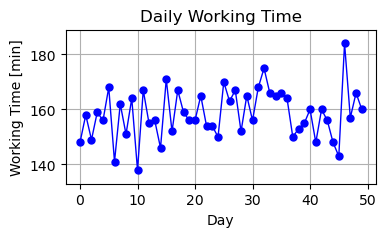

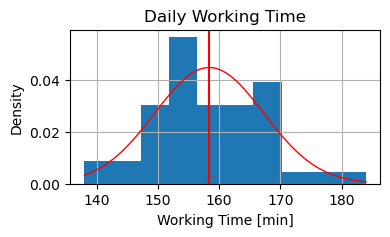

For p = 0.2 and Cargo Bike Range = 35000


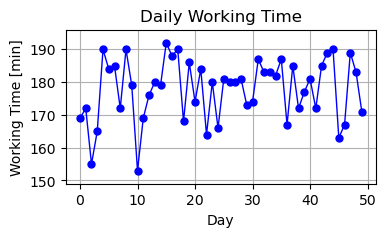

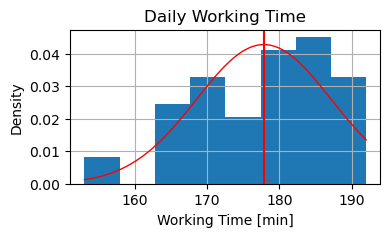

For p = 0.2 and Cargo Bike Range = 40000


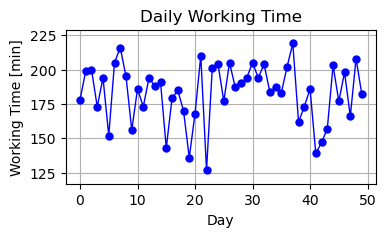

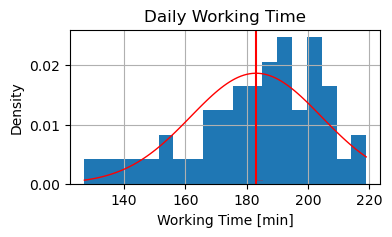

For p = 0.2 and Cargo Bike Range = 45000


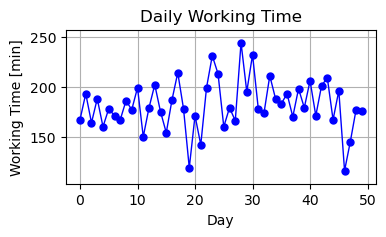

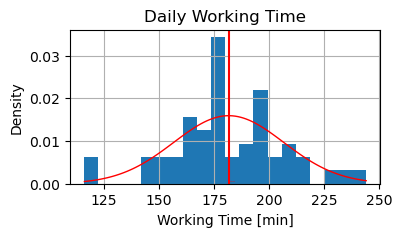

For p = 0.25 and Cargo Bike Range = 30000


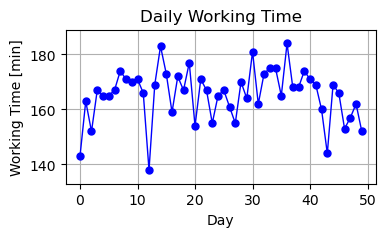

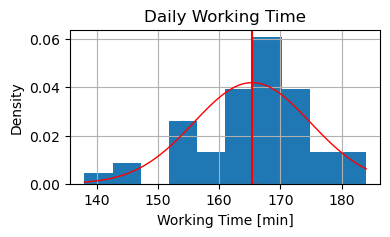

For p = 0.25 and Cargo Bike Range = 35000


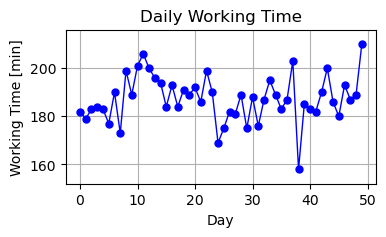

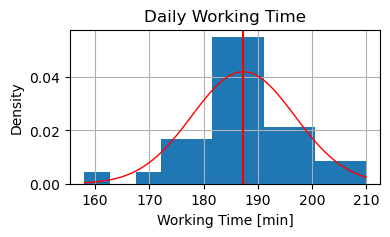

For p = 0.25 and Cargo Bike Range = 40000


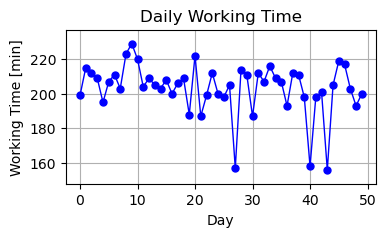

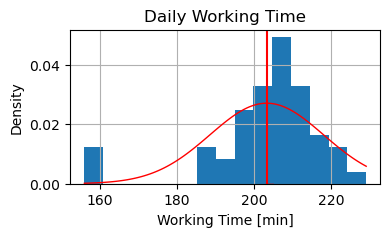

For p = 0.25 and Cargo Bike Range = 45000


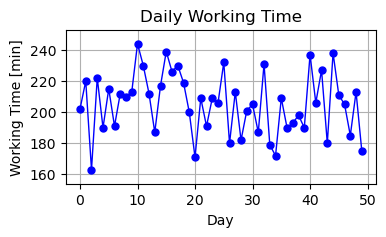

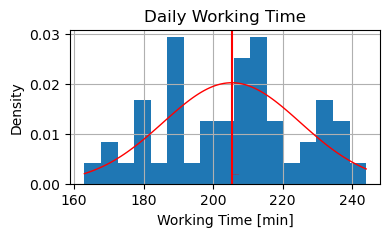

For p = 0.3 and Cargo Bike Range = 30000


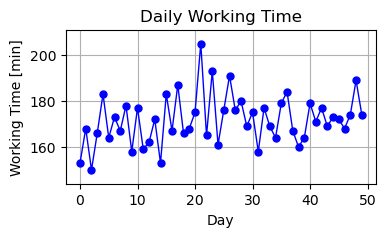

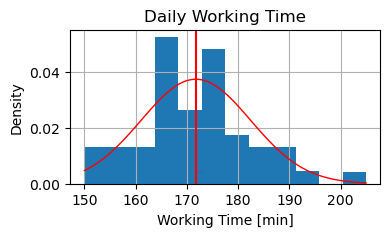

For p = 0.3 and Cargo Bike Range = 35000


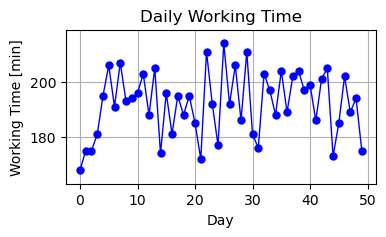

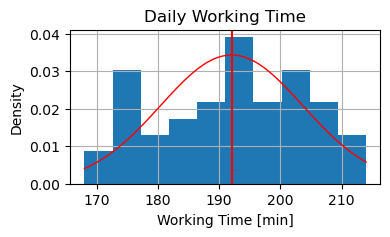

For p = 0.3 and Cargo Bike Range = 40000


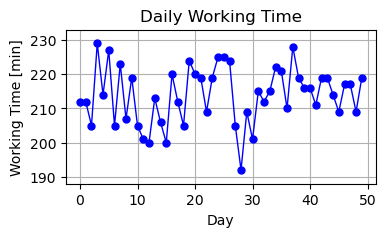

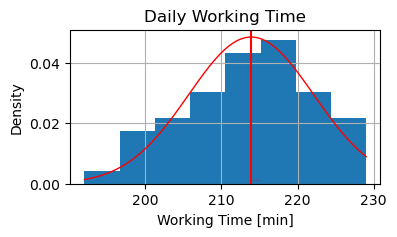

For p = 0.3 and Cargo Bike Range = 45000


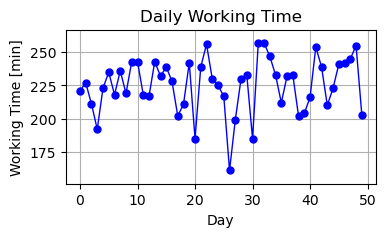

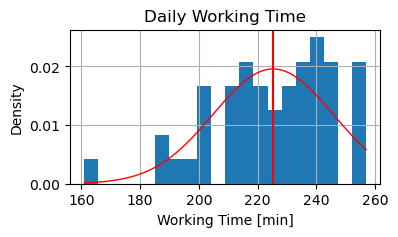

In [47]:
for p in [0.2, 0.25, 0.3]:
    for r in [30000, 35000, 40000, 45000]:
        print(f'For p = {p} and Cargo Bike Range = {r}')
        rec = records[p][r]
        rec.plotWorkingTime()
        rec.histWorkingTime()
        
        

## Analyse Tour Length

For p = 0.2 and Cargo Bike Range = 30000


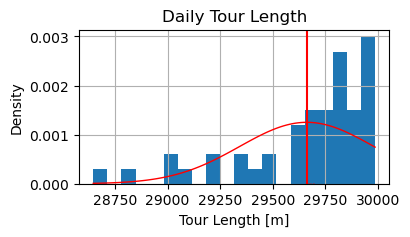

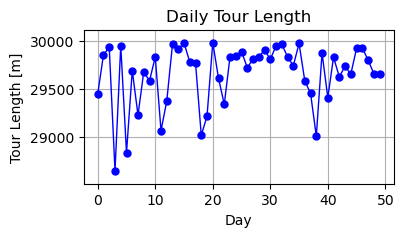

For p = 0.2 and Cargo Bike Range = 35000


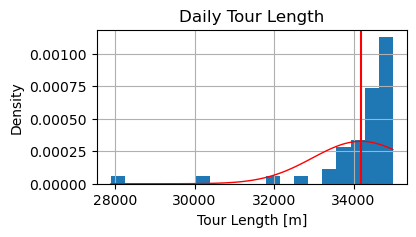

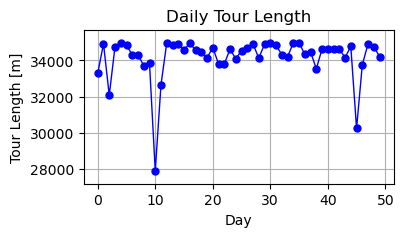

For p = 0.2 and Cargo Bike Range = 40000


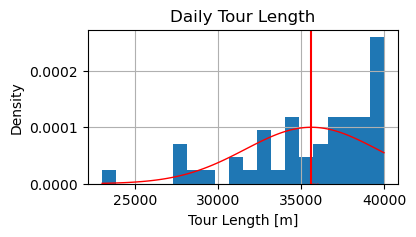

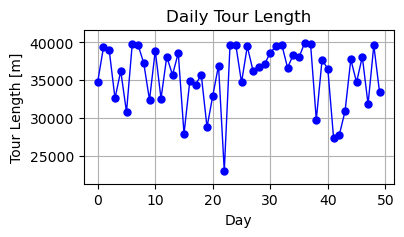

For p = 0.2 and Cargo Bike Range = 45000


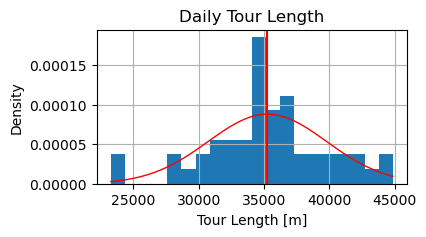

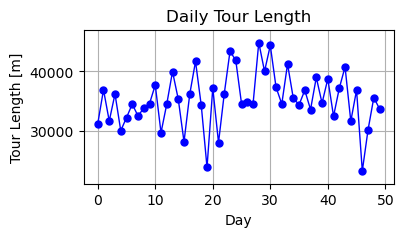

For p = 0.25 and Cargo Bike Range = 30000


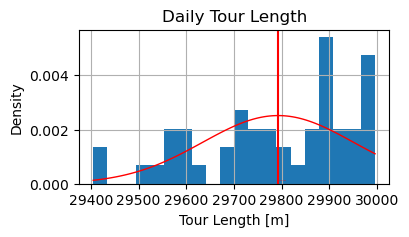

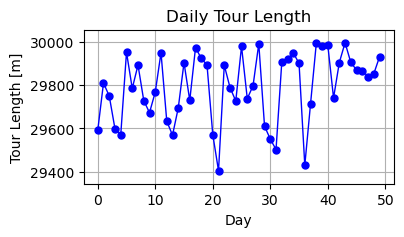

For p = 0.25 and Cargo Bike Range = 35000


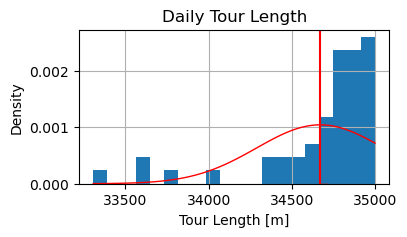

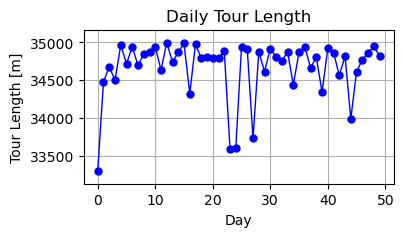

For p = 0.25 and Cargo Bike Range = 40000


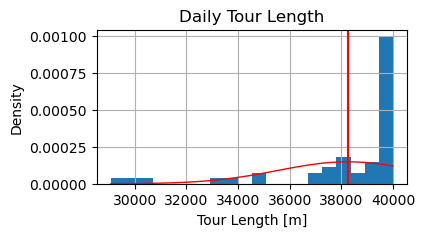

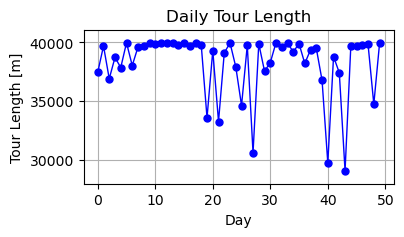

For p = 0.25 and Cargo Bike Range = 45000


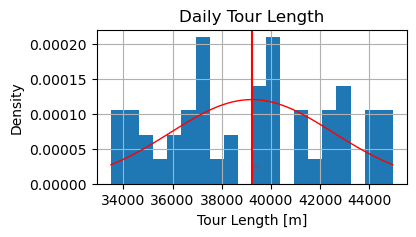

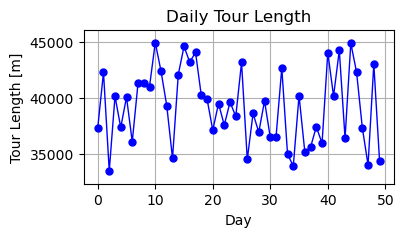

For p = 0.3 and Cargo Bike Range = 30000


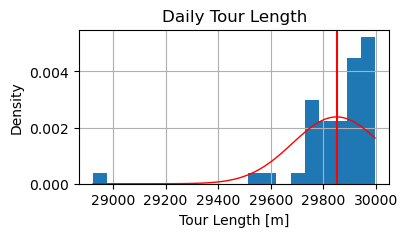

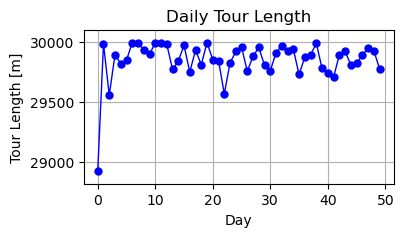

For p = 0.3 and Cargo Bike Range = 35000


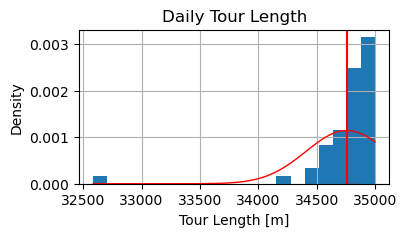

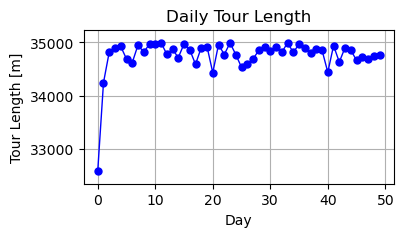

For p = 0.3 and Cargo Bike Range = 40000


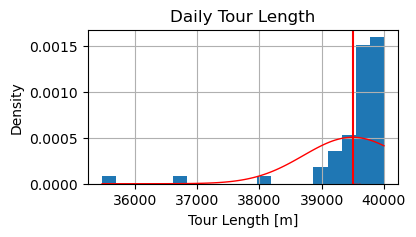

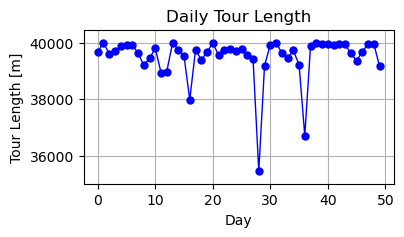

For p = 0.3 and Cargo Bike Range = 45000


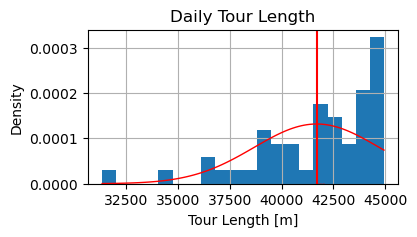

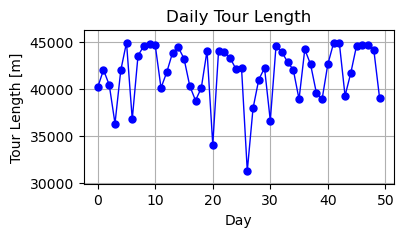

In [90]:
for p in [0.2, 0.25, 0.3]:
    for r in [30000, 35000, 40000, 45000]:
        print(f'For p = {p} and Cargo Bike Range = {r}')
        rec = records[p][r]
        rec.histTourLength()
        rec.plotTourLength()

## Analyse Number of Left-Over Parcels

For p = 0.2 and Cargo Bike Range = 30000


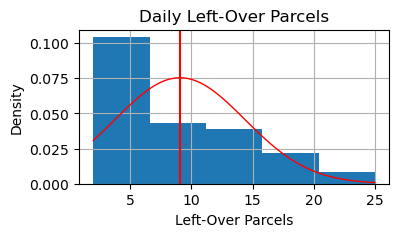

For p = 0.2 and Cargo Bike Range = 35000


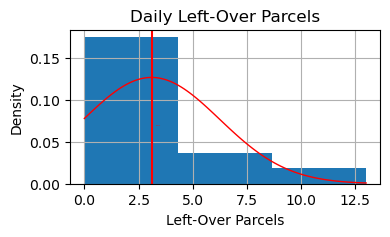

For p = 0.2 and Cargo Bike Range = 40000


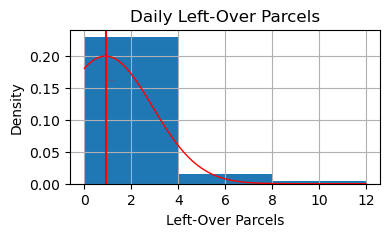

For p = 0.2 and Cargo Bike Range = 45000


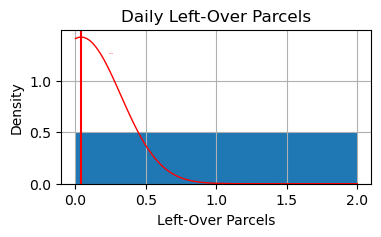

For p = 0.25 and Cargo Bike Range = 30000


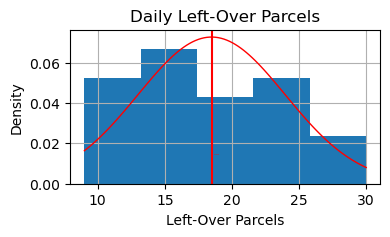

For p = 0.25 and Cargo Bike Range = 35000


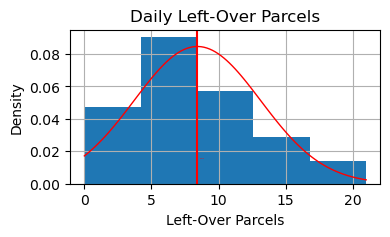

For p = 0.25 and Cargo Bike Range = 40000


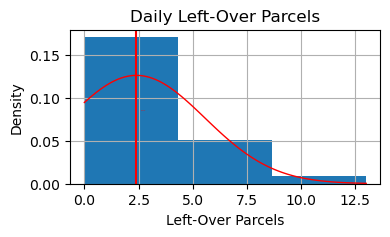

For p = 0.25 and Cargo Bike Range = 45000


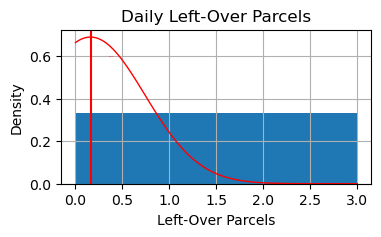

For p = 0.3 and Cargo Bike Range = 30000


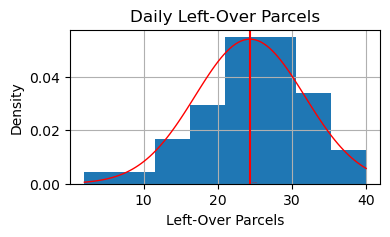

For p = 0.3 and Cargo Bike Range = 35000


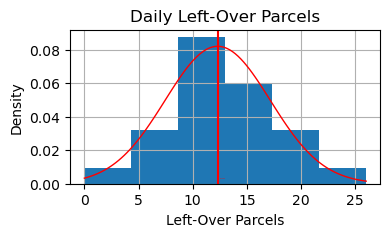

For p = 0.3 and Cargo Bike Range = 40000


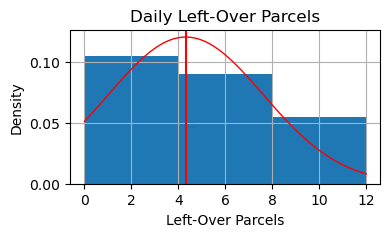

For p = 0.3 and Cargo Bike Range = 45000


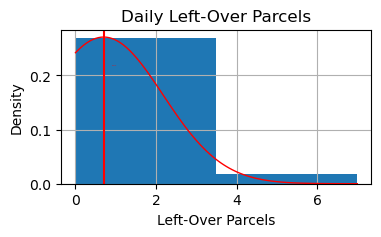

In [54]:
for p in [0.2, 0.25, 0.3]:
    for r in [30000, 35000, 40000, 45000]:
        print(f'For p = {p} and Cargo Bike Range = {r}')
        rec = records[p][r]
        rec.histLeftOver()

For p = 0.2 and Cargo Bike Range = 30000


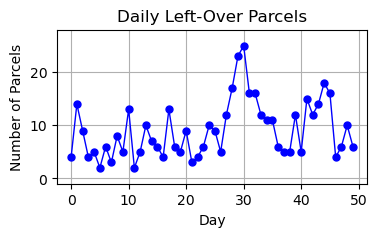

For p = 0.2 and Cargo Bike Range = 35000


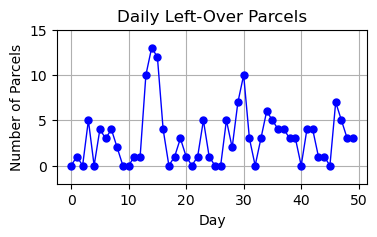

For p = 0.2 and Cargo Bike Range = 40000


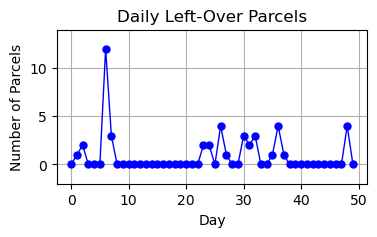

For p = 0.2 and Cargo Bike Range = 45000


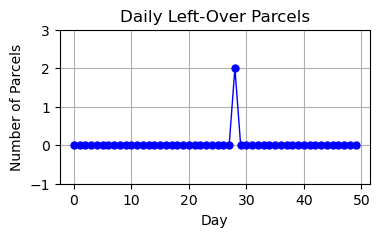

For p = 0.25 and Cargo Bike Range = 30000


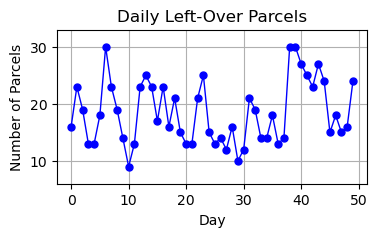

For p = 0.25 and Cargo Bike Range = 35000


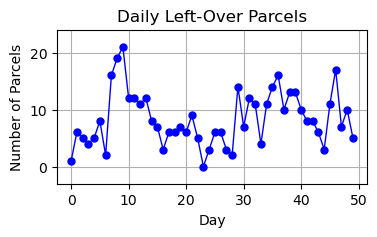

For p = 0.25 and Cargo Bike Range = 40000


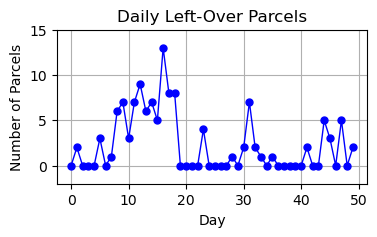

For p = 0.25 and Cargo Bike Range = 45000


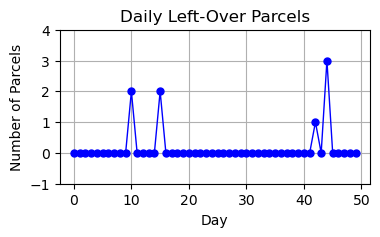

For p = 0.3 and Cargo Bike Range = 30000


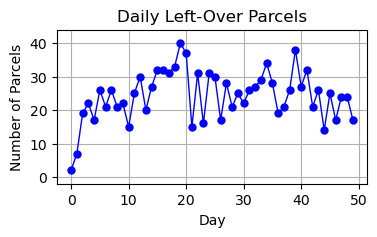

For p = 0.3 and Cargo Bike Range = 35000


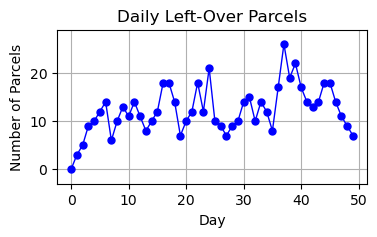

For p = 0.3 and Cargo Bike Range = 40000


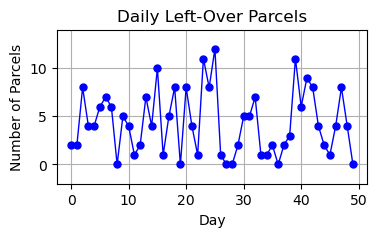

For p = 0.3 and Cargo Bike Range = 45000


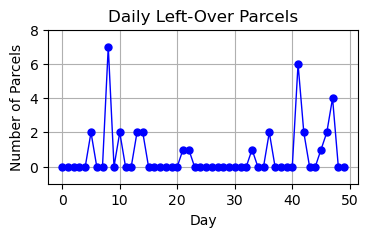

In [76]:
for p in [0.2, 0.25, 0.3]:
    for r in [30000, 35000, 40000, 45000]:
        print(f'For p = {p} and Cargo Bike Range = {r}')
        rec = records[p][r]
        rec.plotLeftOver()

## Analyse Delayed Parcel Delivery

In [57]:
for p in [0.2, 0.25, 0.3]:
    for r in [30000, 35000, 40000, 45000]:
        print(f'For p = {p} and Cargo Bike Range = {r}')
        rec = records[p][r]
        rec.tableParcelDelay()

For p = 0.2 and Cargo Bike Range = 30000
Delivery Delay (1036 parcels)
   None:    606   58.5%
 1 days:    406   39.2%
 2 days:     24    2.3%
For p = 0.2 and Cargo Bike Range = 35000
Delivery Delay (1026 parcels)
   None:    871   84.9%
 1 days:    155   15.1%
For p = 0.2 and Cargo Bike Range = 40000
Delivery Delay (1006 parcels)
   None:    961   95.5%
 1 days:     45    4.5%
For p = 0.2 and Cargo Bike Range = 45000
Delivery Delay (1009 parcels)
   None:   1007   99.8%
 1 days:      2    0.2%
For p = 0.25 and Cargo Bike Range = 30000
Delivery Delay (1278 parcels)
   None:    500   39.1%
 1 days:    632   49.5%
 2 days:    146   11.4%
For p = 0.25 and Cargo Bike Range = 35000
Delivery Delay (1254 parcels)
   None:    837   66.7%
 1 days:    413   32.9%
 2 days:      4    0.3%
For p = 0.25 and Cargo Bike Range = 40000
Delivery Delay (1271 parcels)
   None:   1151   90.6%
 1 days:    120    9.4%
For p = 0.25 and Cargo Bike Range = 45000
Delivery Delay (1228 parcels)
   None:   1220   99

For p = 0.2 and Cargo Bike Range = 30000
For p = 0.2 and Cargo Bike Range = 35000
For p = 0.2 and Cargo Bike Range = 40000
For p = 0.2 and Cargo Bike Range = 45000
For p = 0.25 and Cargo Bike Range = 30000
For p = 0.25 and Cargo Bike Range = 35000
For p = 0.25 and Cargo Bike Range = 40000
For p = 0.25 and Cargo Bike Range = 45000
For p = 0.3 and Cargo Bike Range = 30000
For p = 0.3 and Cargo Bike Range = 35000
For p = 0.3 and Cargo Bike Range = 40000
For p = 0.3 and Cargo Bike Range = 45000


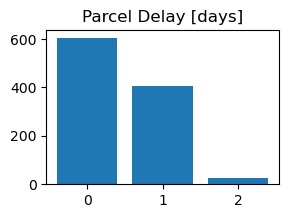

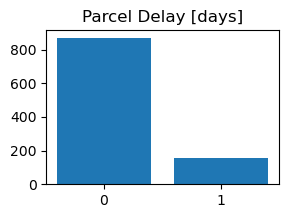

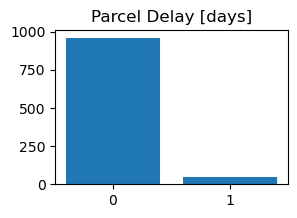

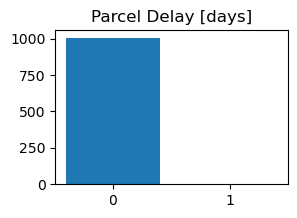

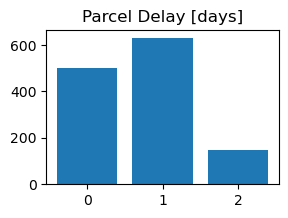

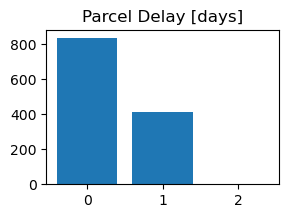

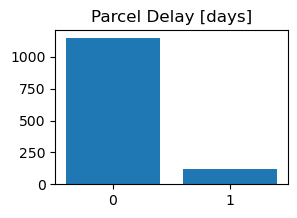

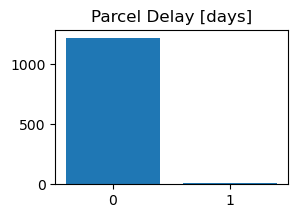

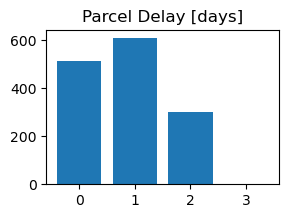

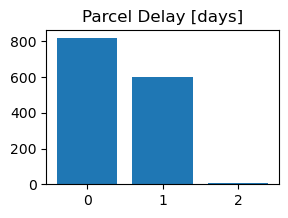

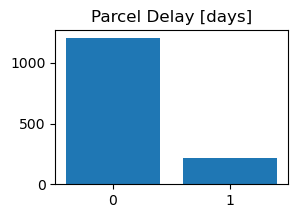

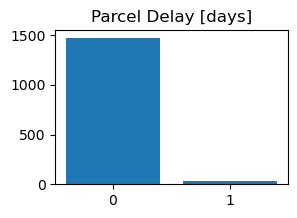

In [59]:
for p in [0.2, 0.25, 0.3]:
    for r in [30000, 35000, 40000, 45000]:
        print(f'For p = {p} and Cargo Bike Range = {r}')
        rec = records[p][r]
        rec.countplotParcelDelay()

For p = 0.2 and Cargo Bike Range = 30000


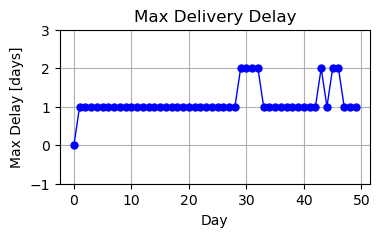

For p = 0.2 and Cargo Bike Range = 35000


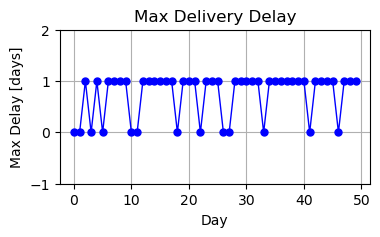

For p = 0.2 and Cargo Bike Range = 40000


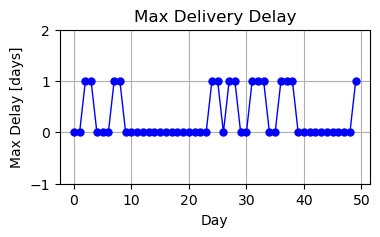

For p = 0.2 and Cargo Bike Range = 45000


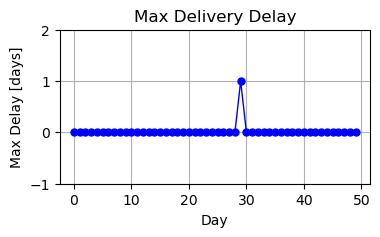

For p = 0.25 and Cargo Bike Range = 30000


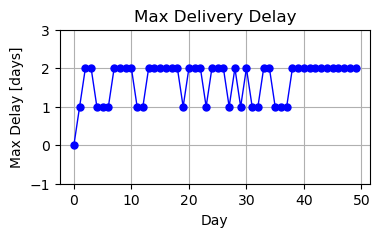

For p = 0.25 and Cargo Bike Range = 35000


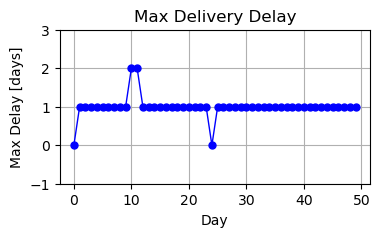

For p = 0.25 and Cargo Bike Range = 40000


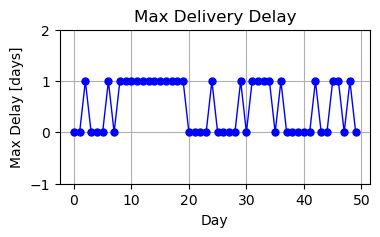

For p = 0.25 and Cargo Bike Range = 45000


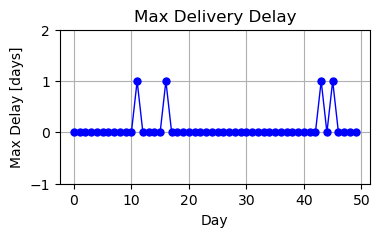

For p = 0.3 and Cargo Bike Range = 30000


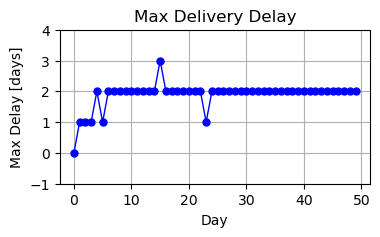

For p = 0.3 and Cargo Bike Range = 35000


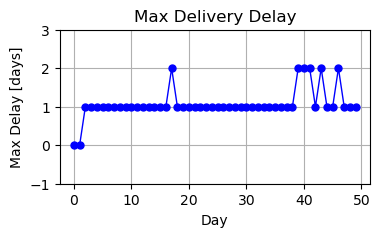

For p = 0.3 and Cargo Bike Range = 40000


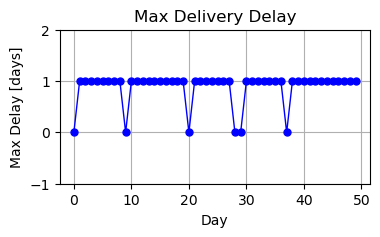

For p = 0.3 and Cargo Bike Range = 45000


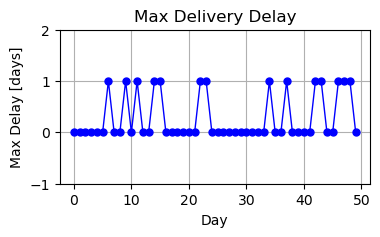

In [60]:
for p in [0.2, 0.25, 0.3]:
    for r in [30000, 35000, 40000, 45000]:
        print(f'For p = {p} and Cargo Bike Range = {r}')
        rec = records[p][r]
        rec.plotParcelDelay()

Simulating the delivery of 1036 parcels over 50 days to 100 customers


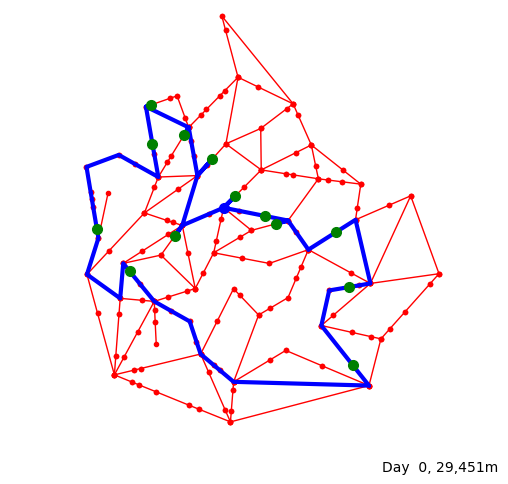

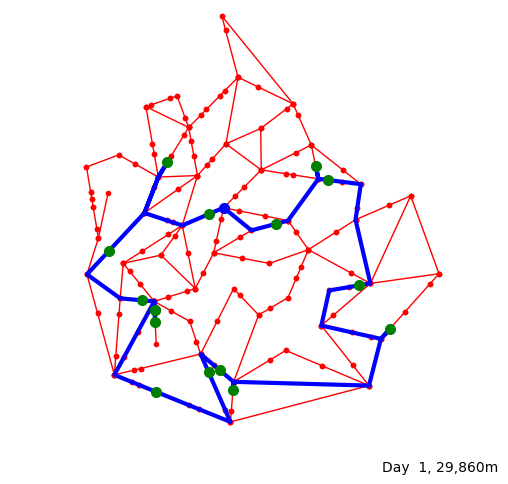

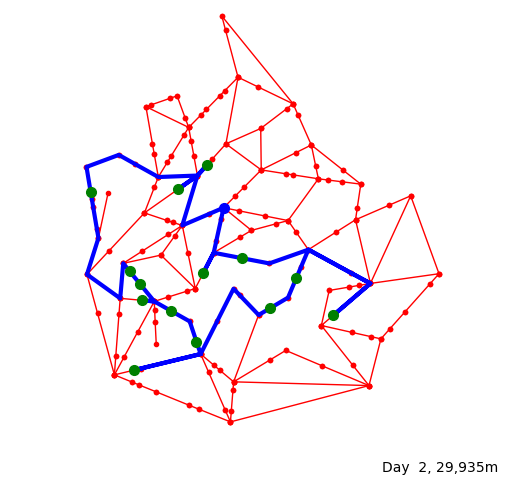

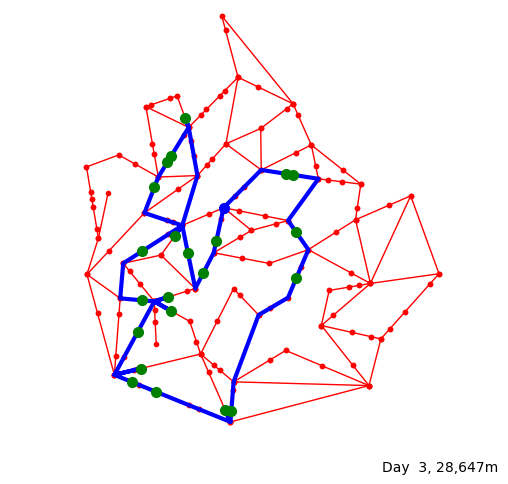

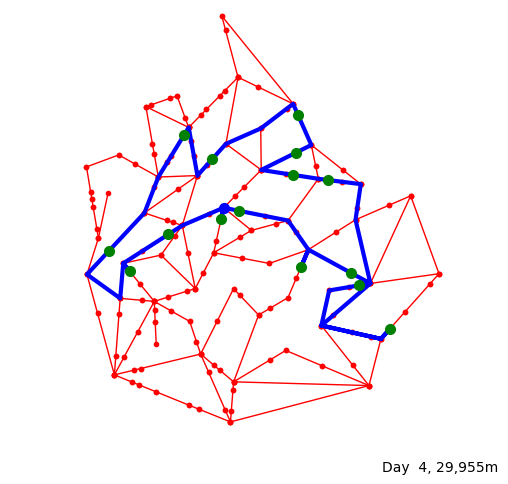

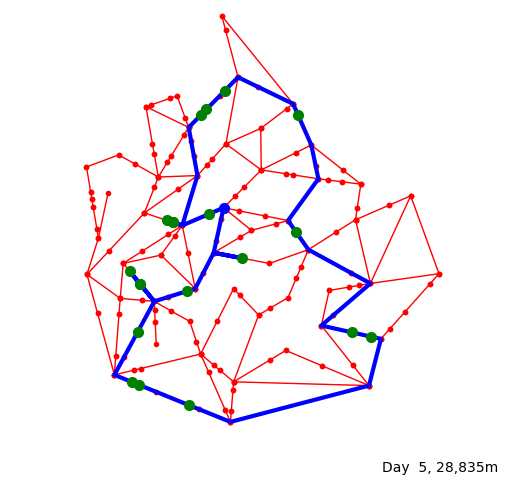

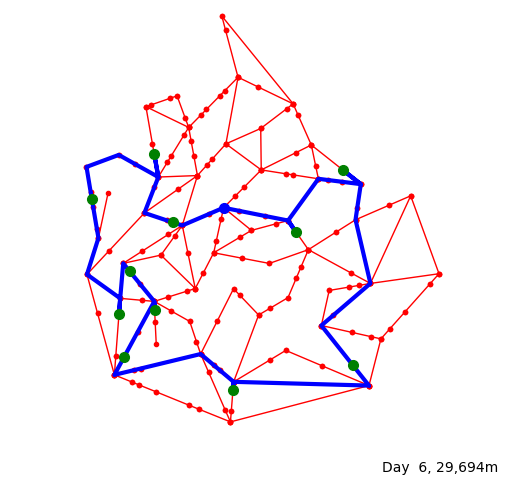

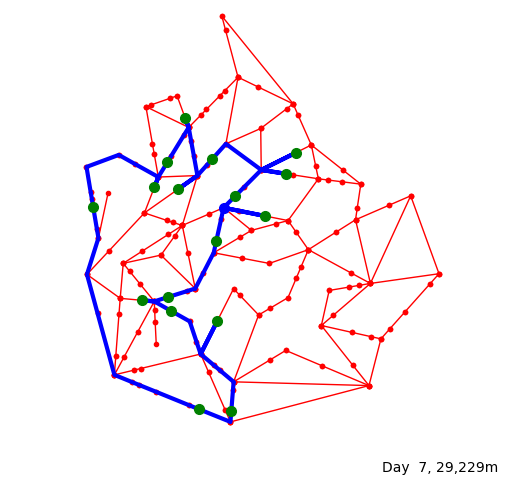

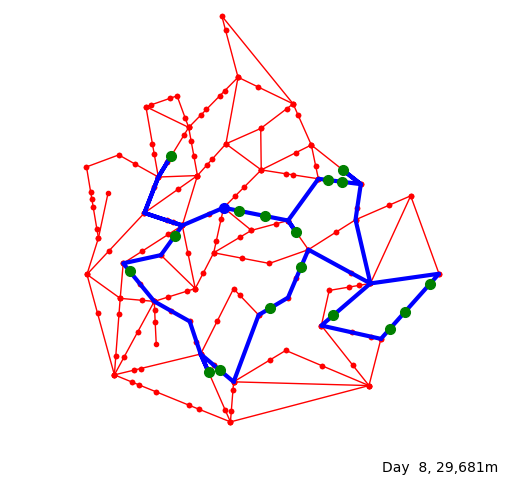

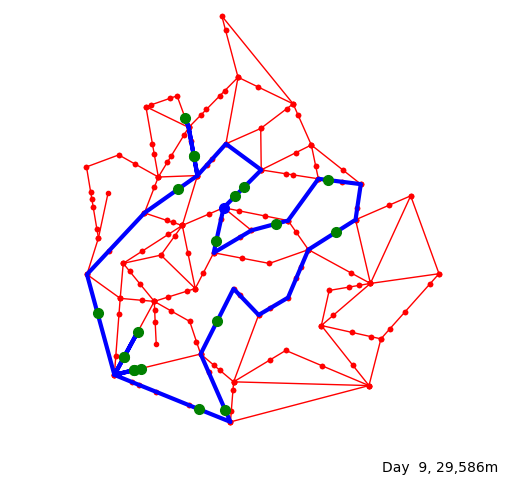

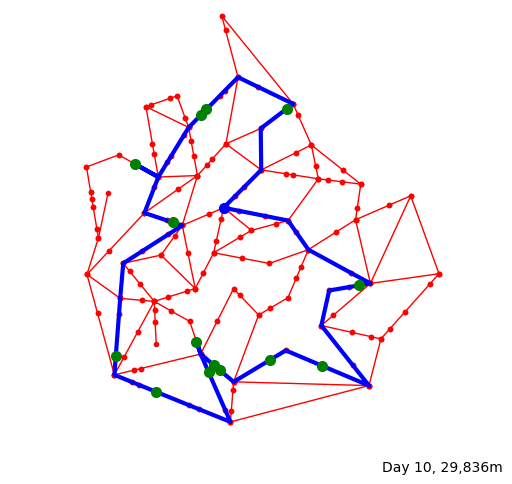

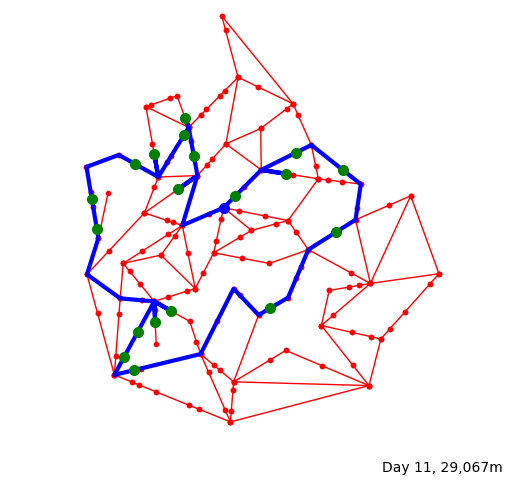

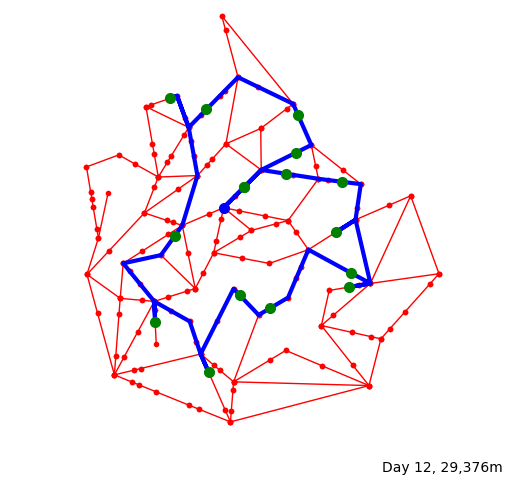

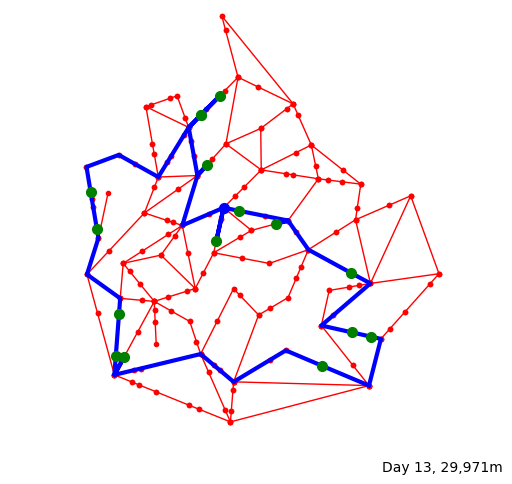

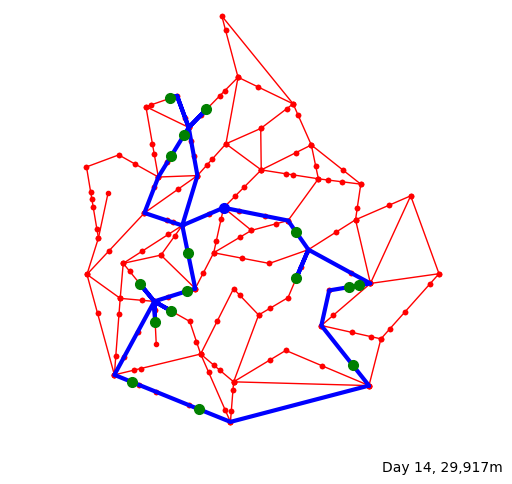

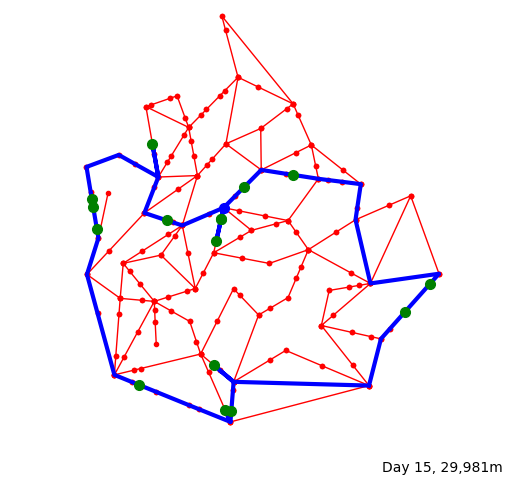

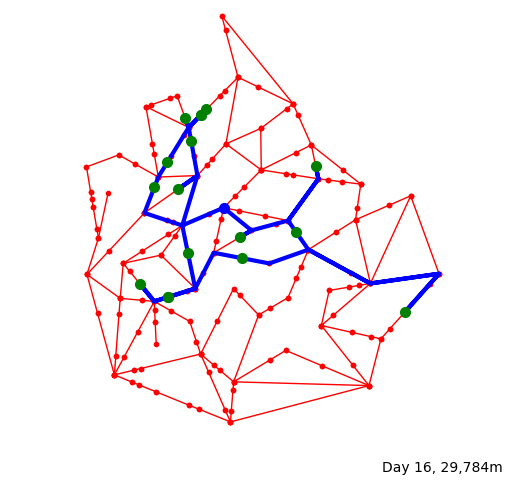

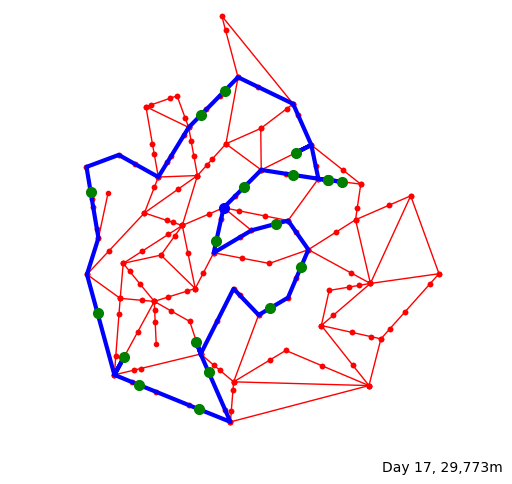

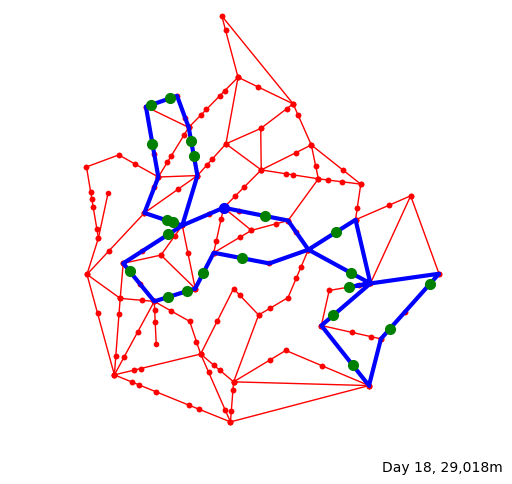

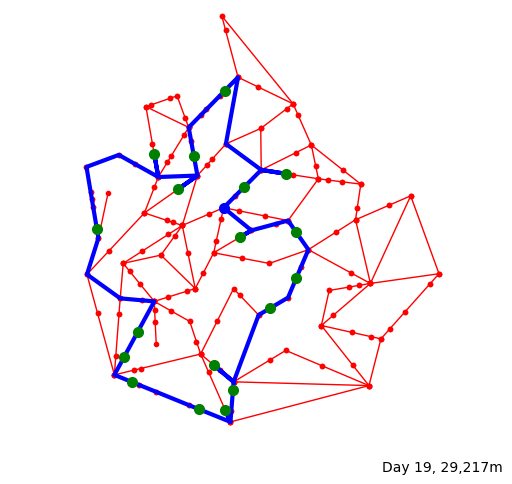

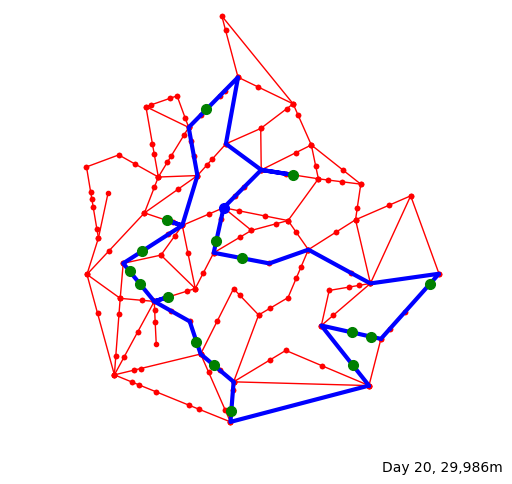

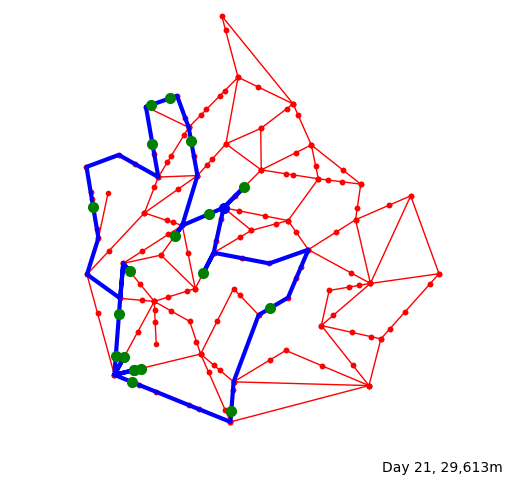

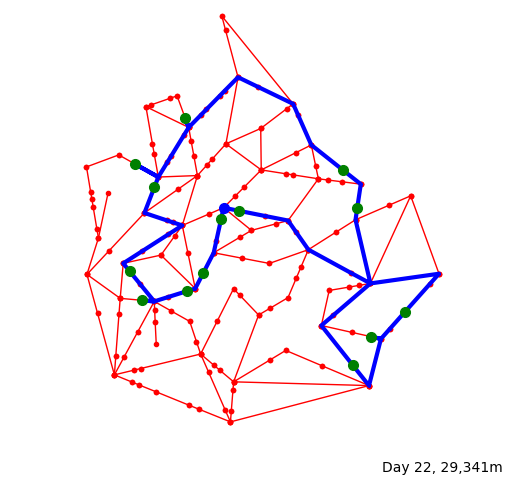

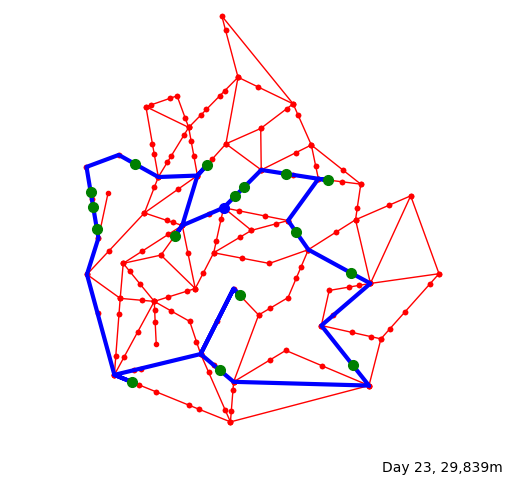

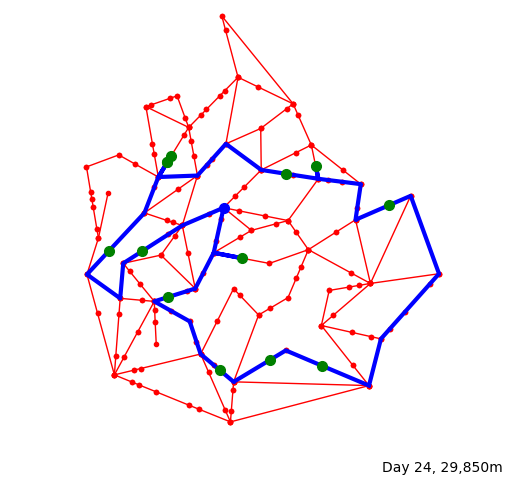

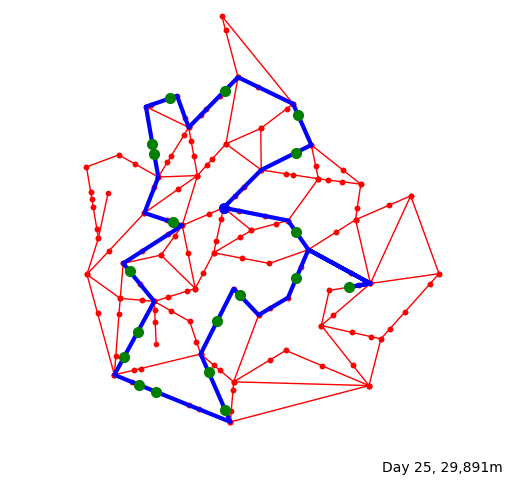

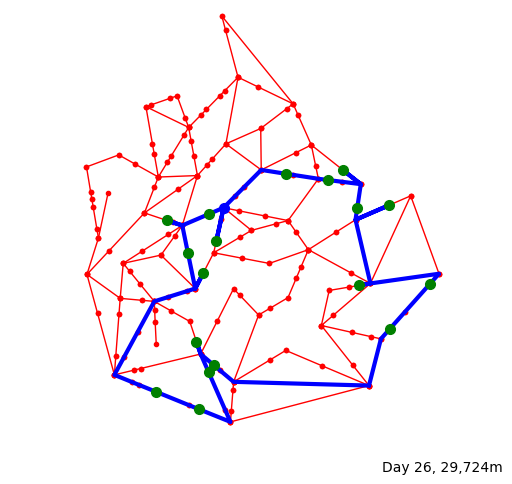

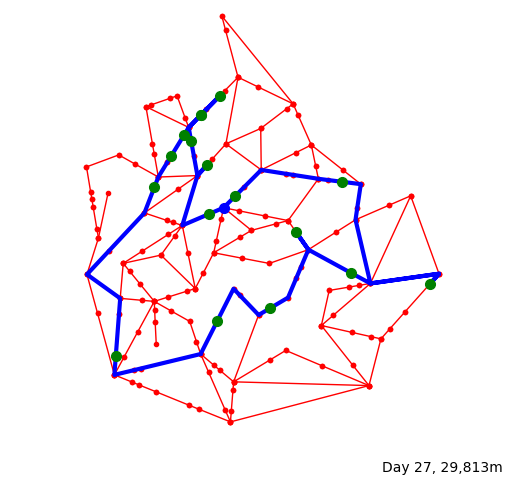

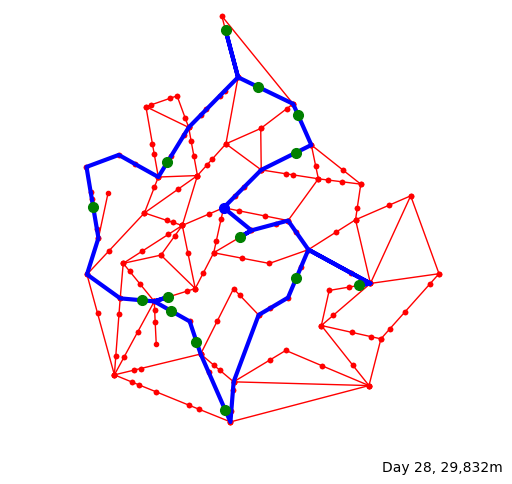

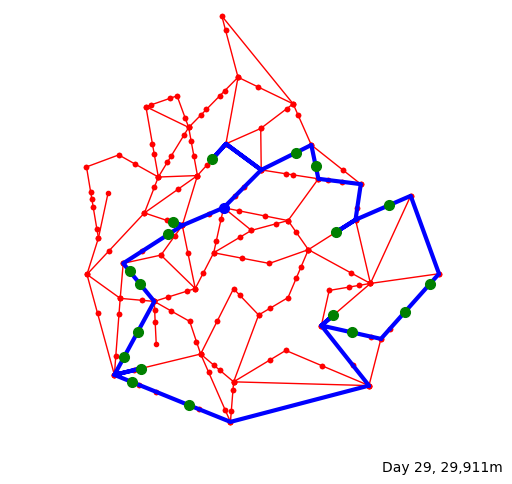

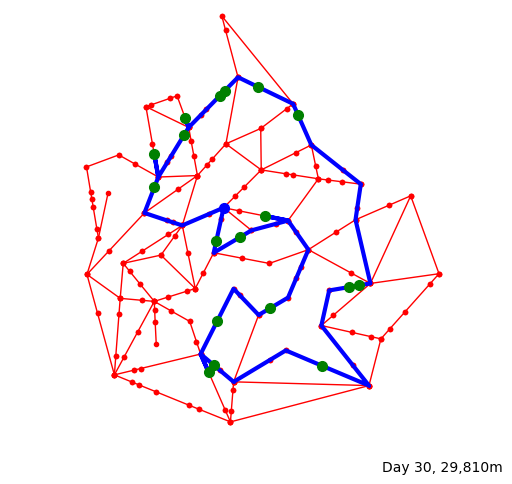

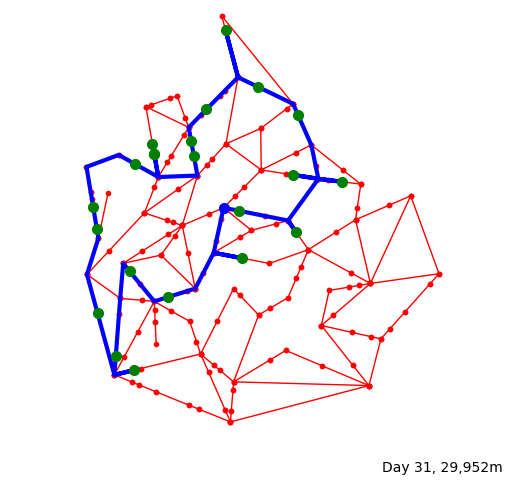

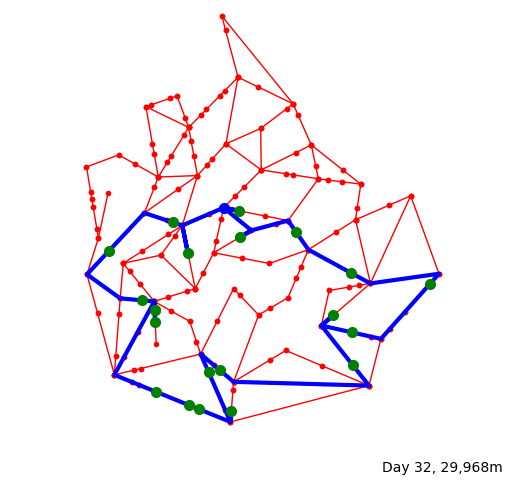

KeyboardInterrupt: 

In [89]:
random.seed(9202)
prime = simulation(M, W, C, days=50, p=0.2, limit=30000, plot=True)

In [92]:
p_values = [0.2, 0.25, 0.3]
r_values = [30000, 35000, 40000, 45000]

# Step 2: Calculate metrics and scores
def calculate_metrics(results):
    # Calculate metrics for each (p, r) pair
    total_distance = {}
    total_delivered = {}
    total_leftover = {}
    total_delay = {}

    for p in p_values:
        for r in r_values:
            rec = results[p][r]
            total_distance[(p, r)] = rec.daily['dist'].sum()
            total_delivered[(p, r)] = (rec.precs['delivered'] != None).sum()
            total_leftover[(p, r)] = rec.daily['left'].sum()
            total_delay[(p, r)] = rec.precs['delay'].sum()

    return total_distance, total_delivered, total_leftover, total_delay

def calculate_scores(total_distance, total_delivered, total_leftover, total_delay):
    scores = {}
    for (p, r) in total_distance.keys():
        scores[(p, r)] = total_delivered[(p, r)] - total_distance[(p, r)] - total_leftover[(p, r)] - total_delay[(p, r)]
    return scores

total_distance, total_delivered, total_leftover, total_delay = calculate_metrics(records)
scores = calculate_scores(total_distance, total_delivered, total_leftover, total_delay)

# Step 3: Determine the best pair
best_pair = max(scores, key=scores.get)

# Step 4: Prepare and print the report
def prepare_report():
    print("Performance Metrics for each (p, r) pair:")
    for (p, r) in scores.keys():
        print(f"p = {p}, r = {r}:")
        print(f"  Total distance traveled: {total_distance[(p, r)]}")
        print(f"  Total parcels delivered: {total_delivered[(p, r)]}")
        print(f"  Total leftover parcels: {total_leftover[(p, r)]}")
        print(f"  Total delivery delay: {total_delay[(p, r)]}")
        print(f"  Score: {scores[(p, r)]}")
    print(f"\nThe recommended (p, r) pair is {best_pair}")

prepare_report()


Performance Metrics for each (p, r) pair:
p = 0.2, r = 30000:
  Total distance traveled: 1483079
  Total parcels delivered: 1036
  Total leftover parcels: 454
  Total delivery delay: 454
  Score: -1482951
p = 0.2, r = 35000:
  Total distance traveled: 1709264
  Total parcels delivered: 1026
  Total leftover parcels: 155
  Total delivery delay: 155
  Score: -1708548
p = 0.2, r = 40000:
  Total distance traveled: 1780580
  Total parcels delivered: 1006
  Total leftover parcels: 45
  Total delivery delay: 45
  Score: -1779664
p = 0.2, r = 45000:
  Total distance traveled: 1762659
  Total parcels delivered: 1009
  Total leftover parcels: 2
  Total delivery delay: 2
  Score: -1761654
p = 0.25, r = 30000:
  Total distance traveled: 1489634
  Total parcels delivered: 1278
  Total leftover parcels: 924
  Total delivery delay: 924
  Score: -1490204
p = 0.25, r = 35000:
  Total distance traveled: 1733445
  Total parcels delivered: 1254
  Total leftover parcels: 421
  Total delivery delay: 421
  